# Классификация клиентов организации с использованием методов машинного обучения

Для раскрытия данной темы был взят датасет с сайта kaggle\
https://www.kaggle.com/datasets/kaushiksuresh147/customer-segmentation?datasetId=841888&sortBy=voteCount

## О наборе данных
### Контекст
Автомобильная компания планирует выйти на новые рынки со своей существующей продукцией (P1, P2, P3, P4 и P5). После интенсивного исследования рынка они пришли к выводу, что поведение нового рынка аналогично их существующему рынку.

На существующем рынке отдел продаж разделил всех клиентов на 4 сегмента (A, B, C, D). Затем они провели сегментированный охват и коммуникацию для другого сегмента клиентов. Эта стратегия сработала для них исключительно хорошо. Они планируют использовать ту же стратегию для новых рынков и выявили 2627 новых потенциальных клиентов.

### Содержание
Этот набор данных был получен в ходе хакатона Analytics Vidhya.

# Начало работы

### Импортируем библиотеки

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam

Сразу отбросим нежелательные сообщения, не влияющие на работу

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# 1. Предварительный анализ

### Чтение данных из файла

Сохраняем исходный датасет и копируем данные оттуда в датафрейм, с которым будет работать в дальнейшем

In [ ]:
train_df = pd.read_csv("./vanifatov/Train.csv")
test_df = pd.read_csv("./vanifatov/Test.csv")
df = pd.concat([train_df, test_df])
df.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


## Изучение структуры данных

Необходимо понять, как устроены данные, какие атрибуты присутствуют в наборе данных, и как они взаимодействуют друг с другом. Для этого могут использоваться различные инструменты, такие как статистические показатели, графики и визуализации.

### Статистические показатели

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10695 entries, 0 to 2626
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               10695 non-null  int64  
 1   Gender           10695 non-null  object 
 2   Ever_Married     10505 non-null  object 
 3   Age              10695 non-null  int64  
 4   Graduated        10593 non-null  object 
 5   Profession       10533 non-null  object 
 6   Work_Experience  9597 non-null   float64
 7   Spending_Score   10695 non-null  object 
 8   Family_Size      10247 non-null  float64
 9   Var_1            10587 non-null  object 
 10  Segmentation     10695 non-null  object 
dtypes: float64(2), int64(2), object(7)
memory usage: 1002.7+ KB


In [ ]:
df.describe()

,ID,Age,Work_Experience,Family_Size
count,10695.000000,10695.000000,9597.000000,10247.000000
mean,463468.088640,43.511828,2.619777,2.844052
std,2600.966411,16.774158,3.390790,1.536427
min,458982.000000,18.000000,0.000000,1.000000
25%,461220.500000,30.000000,0.000000,2.000000
50%,463451.000000,41.000000,1.000000,3.000000
75%,465733.500000,53.000000,4.000000,4.000000
max,467974.000000,89.000000,14.000000,9.000000


### Визуализация данных

Существует встроенная в matplotlib функция визуализирующая график распределения признаков

Но также, можно написать и свою собственную функцию

In [ ]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    # Определяем количество уникальных значений в каждой колонке датафрейма
    nunique = df.nunique()
    # Выбираем только те колонки, которые имеют от 1 до 50 уникальных значений для отображения
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]]
    # Определяем количество строк и колонок в датафрейме
    nRow, nCol = df.shape
    # Создаем список имен колонок датафрейма
    columnNames = list(df)
    # Определяем количество строк графиков
    nGraphRow = int((nCol + nGraphPerRow - 1) / nGraphPerRow)
    # Создаем новый график с заданными размерами
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    # Для каждой колонки отображаем не более nGraphShown графиков

    for i in range(min(nCol, nGraphShown)):\
        # Определяем позицию графика внутри общего графика
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        # Выбираем i-тый столбец
        columnDf = df.iloc[:, i]
        # Если в колонке нет числовых значений, то строим столбчатую диаграмму
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            # Считаем количество уникальных значений в колонке
            valueCounts = columnDf.value_counts()
            # Строим столбчатую диаграмму
            valueCounts.plot.bar()
        # Иначе строим гистограмму
        else:
            # Строим гистограмму
            columnDf.hist()
        # Подписываем ось y
        plt.ylabel('counts')
        # Поворачиваем названия значений на оси x на 90 градусов
        plt.xticks(rotation = 90)
        # Добавляем заголовок для графика
        plt.title(f'{columnNames[i]} (column {i})')
    # Настраиваем расположение графиков
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    # Отображаем графики
    plt.show()

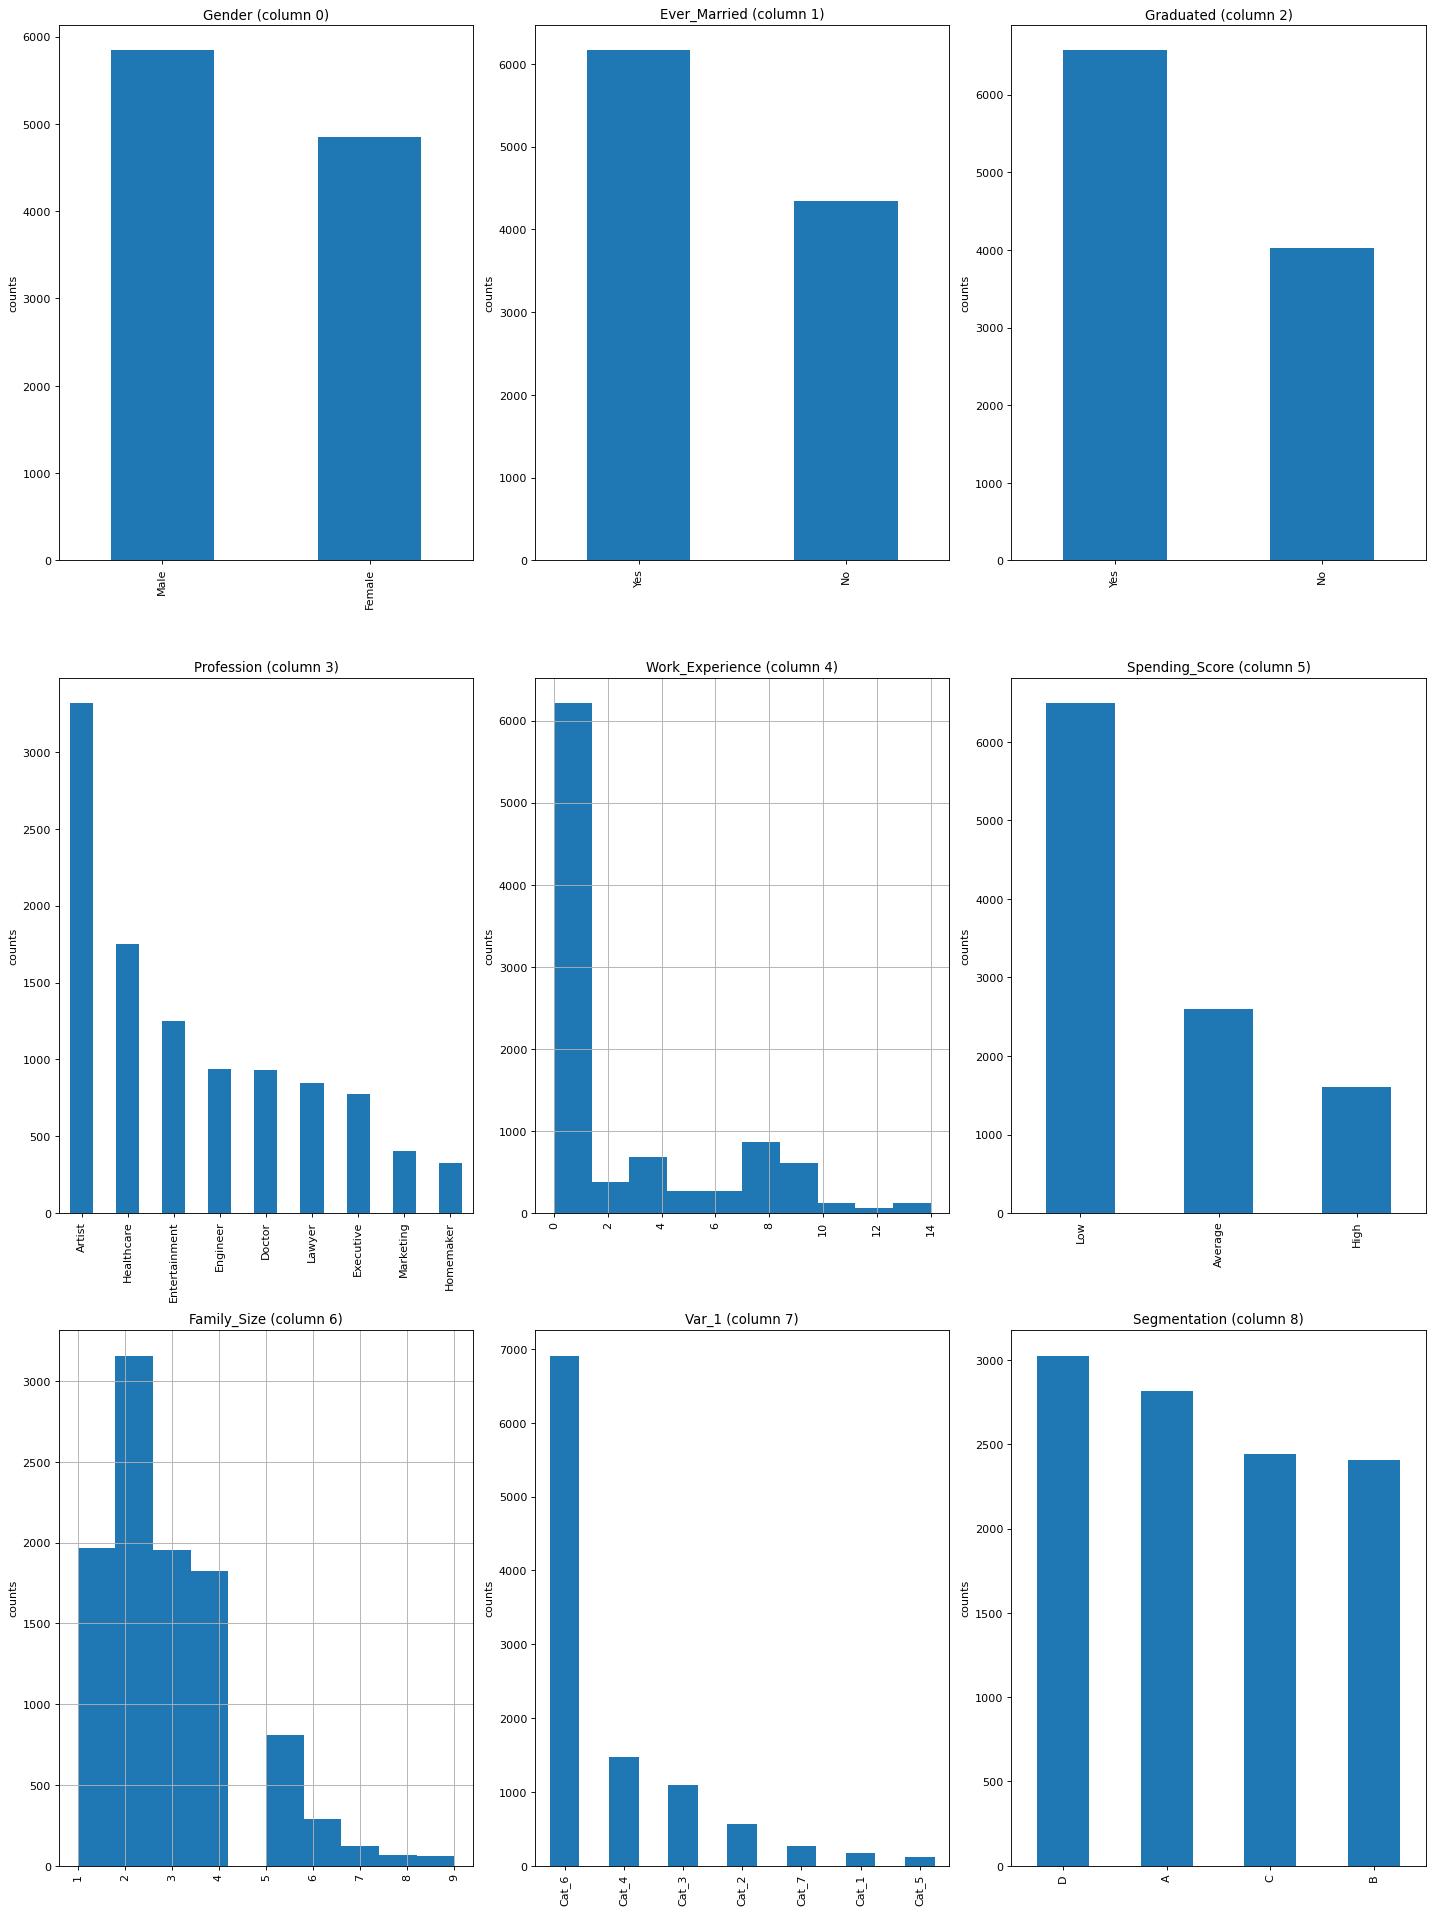

In [ ]:
plotPerColumnDistribution(df, 9, 3)

#### Графики по признакам

In [ ]:
df.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


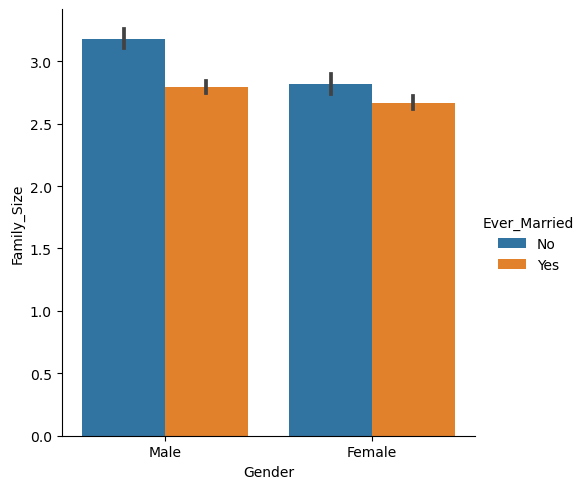

In [ ]:
sns.catplot(data=df, x="Gender", y="Family_Size", hue="Ever_Married", kind="bar")
plt.show()

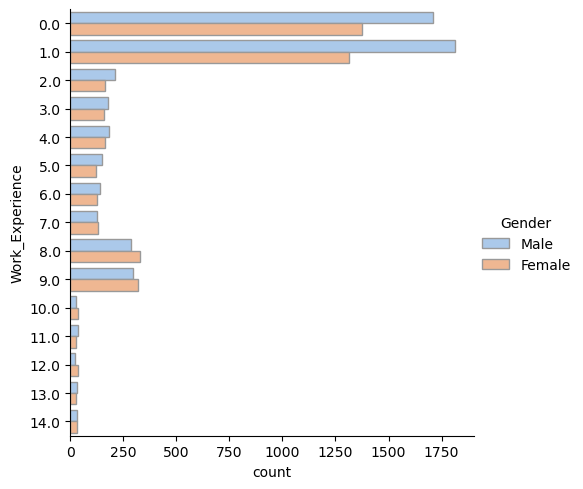

In [ ]:
sns.catplot(data=df, y="Work_Experience", hue="Gender", kind="count", palette="pastel", edgecolor=".6")
plt.show()

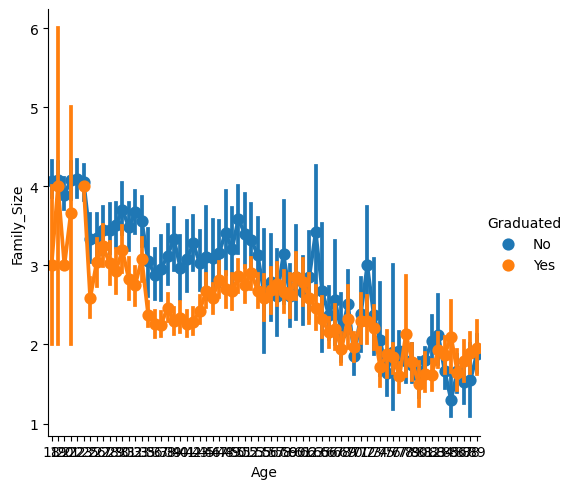

In [ ]:
sns.catplot(data=df, x="Age", y="Family_Size", hue="Graduated", kind="point")
plt.show()

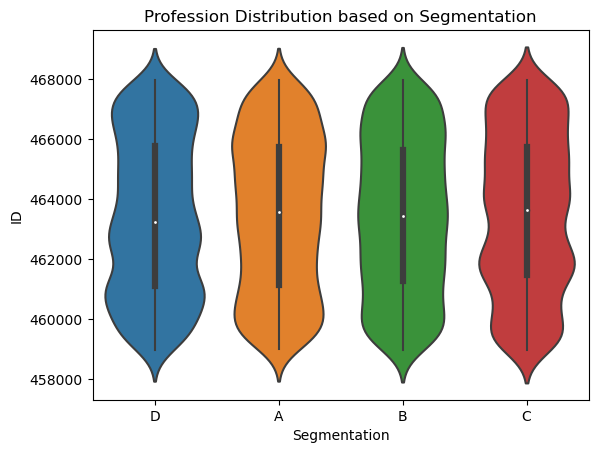

In [ ]:
# Profession based on Segmentation
sns.violinplot(x='Segmentation', y='ID', data=df)
plt.title("Profession Distribution based on Segmentation")
plt.show()

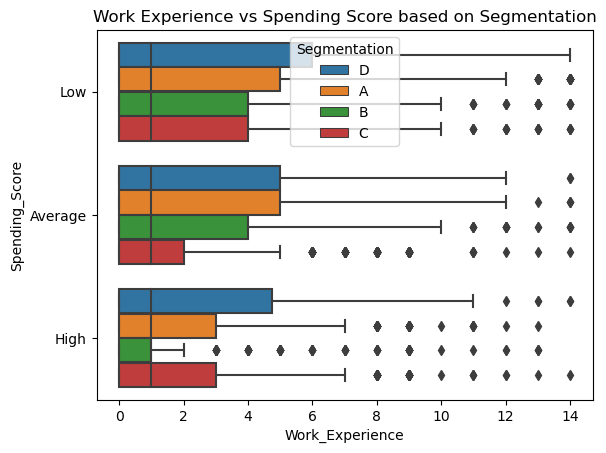

In [ ]:
# Work Experience vs Spending Score based on Segmentation
sns.boxplot(x='Work_Experience', y='Spending_Score', hue='Segmentation', data=df)
plt.title("Work Experience vs Spending Score based on Segmentation")
plt.show()

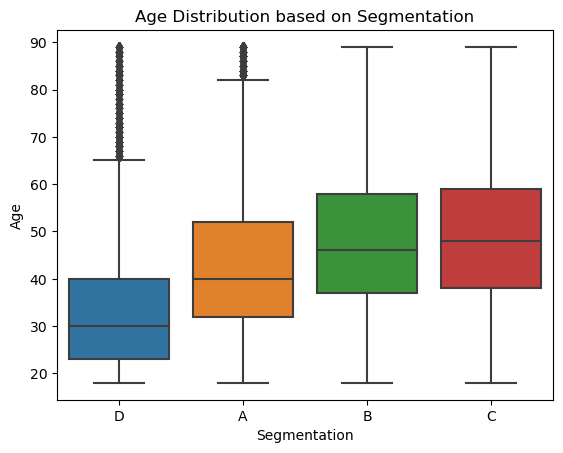

In [ ]:
# Age based on Segmentation
sns.boxplot(x='Segmentation', y='Age', data=df)
plt.title("Age Distribution based on Segmentation")
plt.show()

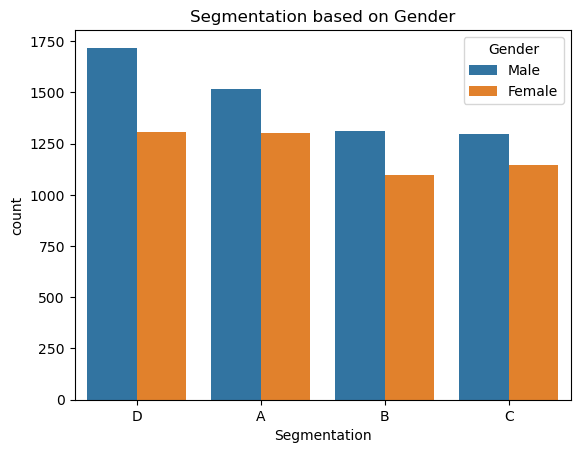

In [ ]:
# Segmentation based on Gender
sns.countplot(x='Segmentation', hue='Gender', data=df)
plt.title("Segmentation based on Gender")
plt.show()

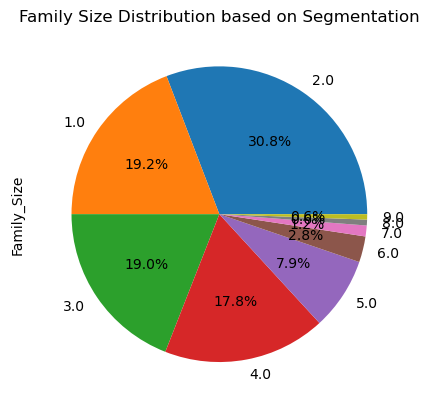

In [ ]:
# Family Size based on Segmentation
df['Family_Size'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title("Family Size Distribution based on Segmentation")
plt.show()

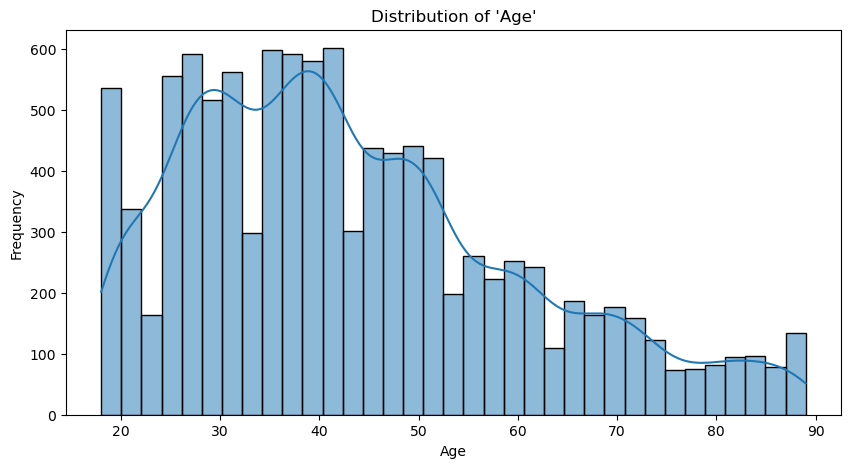

In [ ]:
# Plot the distribution of 'Age'
plt.figure(figsize=(10,5))
sns.histplot(df['Age'], kde=True)
plt.title("Distribution of 'Age'")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

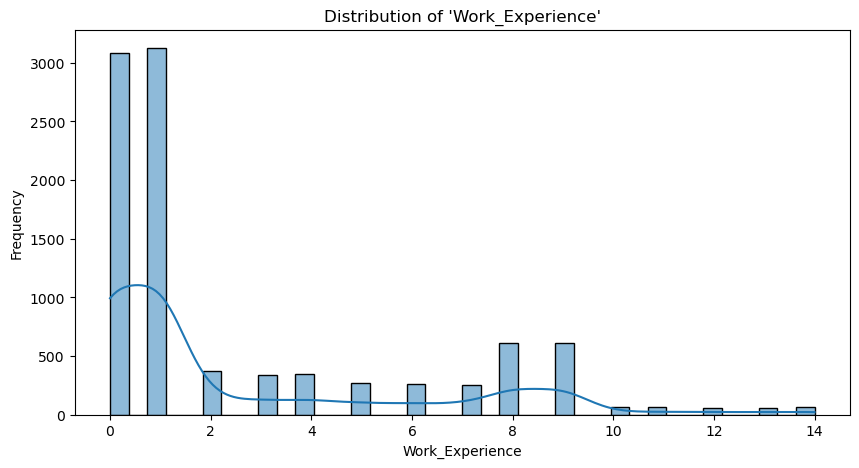

In [ ]:
# Plot the distribution of 'Work_Experience'
plt.figure(figsize=(10,5))
sns.histplot(df['Work_Experience'], kde=True)
plt.title("Distribution of 'Work_Experience'")
plt.xlabel("Work_Experience")
plt.ylabel("Frequency")
plt.show()

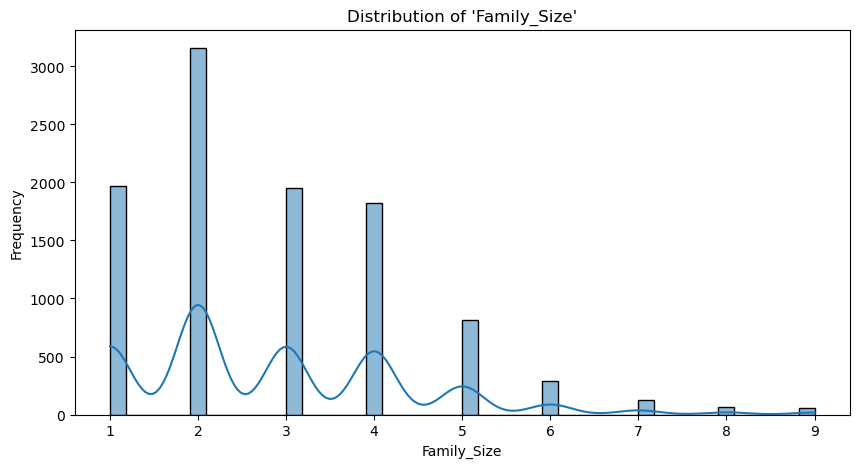

In [ ]:
# Plot the distribution of 'Family_Size'
plt.figure(figsize=(10,5))
sns.histplot(df['Family_Size'], kde=True)
plt.title("Distribution of 'Family_Size'")
plt.xlabel("Family_Size")
plt.ylabel("Frequency")
plt.show()

## Оценка качества данныx

Необходимо проверить данные на наличие ошибок, пропусков, выбросов, дубликатов и других проблем. Если такие проблемы обнаружены, их нужно решить до начала обучения.

### Проверка наличия пропусков данных

В библиотеке pandas для проверки наличия пропущенных значений можно использовать метод isna() для DataFrame или Series. Метод isna() возвращает булеву маску, где True означает наличие пропущенного значения.

In [ ]:
df.nunique() # количество уникальных значений в каждом столбце

ID                 8363
Gender                2
Ever_Married          2
Age                  67
Graduated             2
Profession            9
Work_Experience      15
Spending_Score        3
Family_Size           9
Var_1                 7
Segmentation          4
dtype: int64

In [ ]:
df.isna().sum(axis=0) # пропущенные значения

ID                    0
Gender                0
Ever_Married        190
Age                   0
Graduated           102
Profession          162
Work_Experience    1098
Spending_Score        0
Family_Size         448
Var_1               108
Segmentation          0
dtype: int64

Видим пропущенные значения

### Заполнение пропущенных значений

Пропущенные значения (missing values) в датасете могут возникать по разным причинам: ошибки сбора данных, ошибки при вводе данных, данные не предоставлены, данные потеряны и т.д. Наличие пропущенных значений в датасете может привести к некорректным результатам анализа данных, поэтому важно обработать эти пропущенные значения.

Существует несколько методов заполнения пропущенных значений в датасете:

Удаление строк или столбцов с пропущенными значениями: данный метод можно использовать, если пропущенные значения не занимают большую долю в датасете. Однако при этом может потеряться много информации.

Заполнение средним значением: данный метод можно использовать для числовых данных. Пропущенные значения заменяются на среднее значение по столбцу. Однако при использовании этого метода важно учитывать распределение данных и возможные выбросы.

Заполнение медианой: данный метод также можно использовать для числовых данных. Пропущенные значения заменяются на медианное значение по столбцу. Этот метод более устойчив к выбросам, чем метод среднего значения.

Заполнение модой: данный метод можно использовать для категориальных данных. Пропущенные значения заменяются на моду по столбцу, то есть на наиболее часто встречающееся значение.

Использование моделей машинного обучения: можно использовать модели машинного обучения для заполнения пропущенных значений. Например, можно обучить модель регрессии для заполнения пропущенных числовых значений или модель классификации для заполнения пропущенных категориальных значений.

При выборе метода заполнения пропущенных значений важно учитывать тип данных, распределение данных, наличие выбросов и объем пропущенных значений.

В случае с категориальным признаком, наиболее простым решением, если пропущенные значения не составляют большинство признака, будет замена наиболее часто встречающимся значением

Ниже пример кода как можно заполнить данные с уже предобработанными некорректными пропущенными значениями

In [ ]:
# example['A'].fillna(example['A'].mean()[0], inplace=True)

В случае с числовым признаком, если опять же, большая часть данных не пропущена, заполнить его среднем значением

Ниже пример кода как можно заполнить данные с уже предобработанными некорректными пропущенными значениями

In [ ]:
# example['B'].fillna(example['B'].mode()[0], inplace=True)

#### Работа с пропущенными значениями

In [ ]:
df.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


In [ ]:
df.isna().sum(axis=0) # пропущенные значения

ID                    0
Gender                0
Ever_Married        190
Age                   0
Graduated           102
Profession          162
Work_Experience    1098
Spending_Score        0
Family_Size         448
Var_1               108
Segmentation          0
dtype: int64

In [ ]:
df['Ever_Married'].fillna(df['Ever_Married'].mode()[0], inplace=True)
df['Graduated'].fillna(df['Graduated'].mode()[0], inplace=True)
df['Profession'].fillna(df['Profession'].mode()[0], inplace=True)
df['Work_Experience'].fillna(0, inplace=True) #0
df['Family_Size'].fillna(0, inplace=True) #0
df['Var_1'].fillna(df['Var_1'].mode()[0], inplace=True)

Количество опыта работы и размер семьи лучше заменить на 0, потому что отсутсвие этих данных косвенно свидетельсвует об этом

In [ ]:
df.isna().sum(axis=0) # пропущенные значения

ID                 0
Gender             0
Ever_Married       0
Age                0
Graduated          0
Profession         0
Work_Experience    0
Spending_Score     0
Family_Size        0
Var_1              0
Segmentation       0
dtype: int64

### Изучение выбросов

Эта функция определяет диапазон выбросов для заданного столбца в данных.
Она вычисляет первый квартиль (25-й перцентиль), третий квартиль (75-й перцентиль) и межквартильный размах (IQR), а затем вычисляет нижнюю и верхнюю границы диапазона выбросов, используя множитель (по умолчанию 1.5).

Функция также выводит количество строк, которые будут затронуты выбросами и возвращает значения нижней и верхней границ диапазона выбросов.

In [ ]:
df.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,0.0,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,0.0,High,6.0,Cat_6,A


Строим ящик с усами для числовых признаков

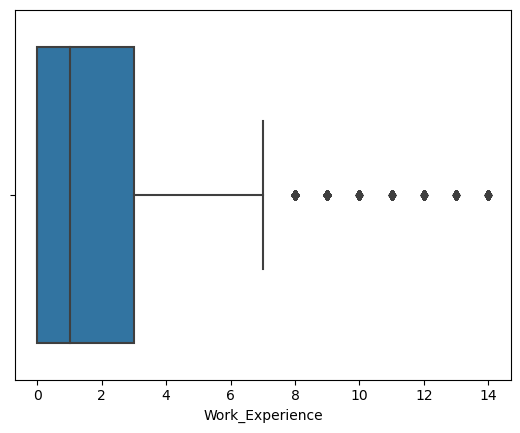

In [ ]:
sns.boxplot(data=df, x="Work_Experience")
plt.show()

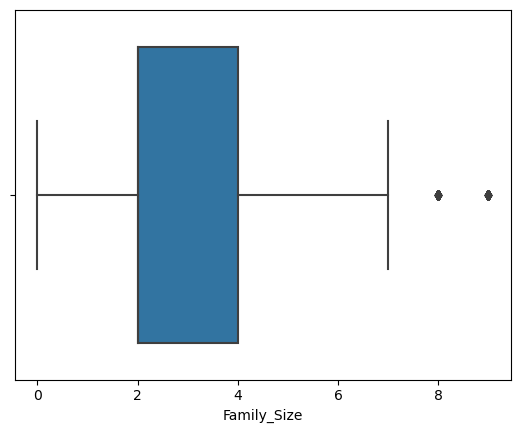

In [ ]:
sns.boxplot(data=df, x="Family_Size")
plt.show()

In [ ]:
# Определим диапазон выбросов
def get_clean(df, column):
    # Определяем первый и третий квартили и межквартильный размах
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1

    # Определяем границы выбросов на основе межквартильного размаха
    lower = q1-iqr*1.5
    upper = q3+iqr*1.5

    # Отбираем только те строки, где значение столбца column находится внутри границ выбросов
    df_clean = df[(upper>=df[column]) & (lower<=df[column])]

    # Возвращаем новый датафрейм без выбросов
    return df_clean

In [ ]:
df.Work_Experience.shape

(10695,)

In [ ]:
a = get_clean(df, "Work_Experience")
a

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,0.0,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,0.0,High,6.0,Cat_6,A
...,...,...,...,...,...,...,...,...,...,...,...
2620,467949,Male,No,21,No,Healthcare,1.0,Low,4.0,Cat_4,D
2621,467950,Female,No,35,Yes,Entertainment,1.0,Low,2.0,Cat_6,D
2623,467958,Female,No,35,Yes,Doctor,1.0,Low,1.0,Cat_6,A
2624,467960,Female,No,53,Yes,Entertainment,0.0,Low,2.0,Cat_6,C


In [ ]:
a.shape

(9159, 11)

Хоть выбросы и присутсвуют, я бы не стал их удалять, потому что это довольно значимая часть данных

## Исследование взаимосвязей

Необходимо исследовать взаимосвязи между переменными, чтобы определить, какие факторы оказывают влияние на целевую переменную. Для этого могут использоваться корреляционные матрицы, диаграммы рассеяния и другие графики.

### Матрица корреляции

Существует встроенная в seaborn функция визуализирующая матрицу корреляций признаков

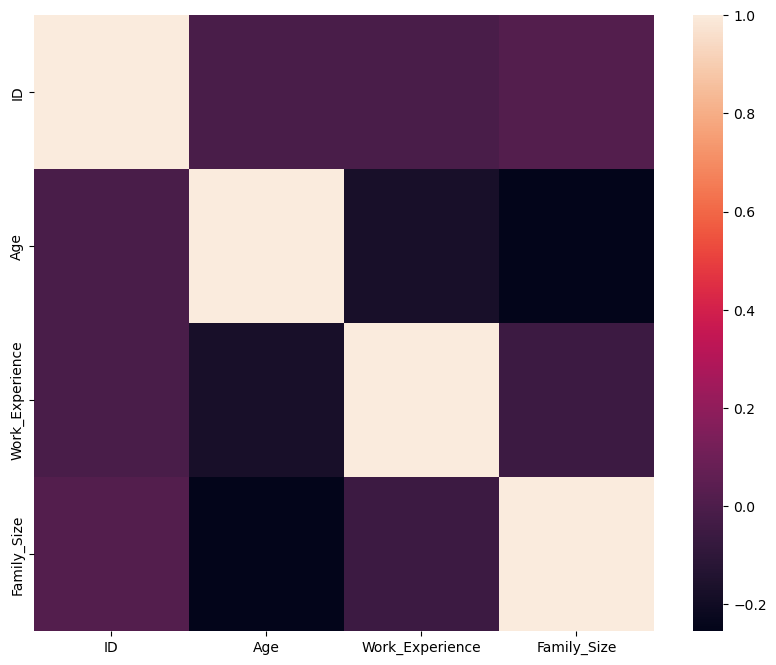

In [ ]:
# Создание графика и задание его размеров
fig = plt.figure(figsize=(10, 8))

sns.heatmap(df.corr(), annot = False) # annot добавляет значение корреляции

# Отображение графика
plt.show()

Но также, можно написать и свою собственную функцию

In [ ]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
#     filename = df.dataframeName
    df = df.dropna('columns')
    # удаляем столбцы с NaN
    df = df[[col for col in df if df[col].nunique() > 1]]
    # оставляем столбцы, где более 1 уникального значения
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    # вычисляем корреляцию
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    # отображаем матрицу корреляции
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    # устанавливаем подписи для осей x и y
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    # добавляем цветовую шкалу
    plt.title(f'Correlation Matrix', fontsize=20)
    # добавляем заголовок графика
    plt.show()

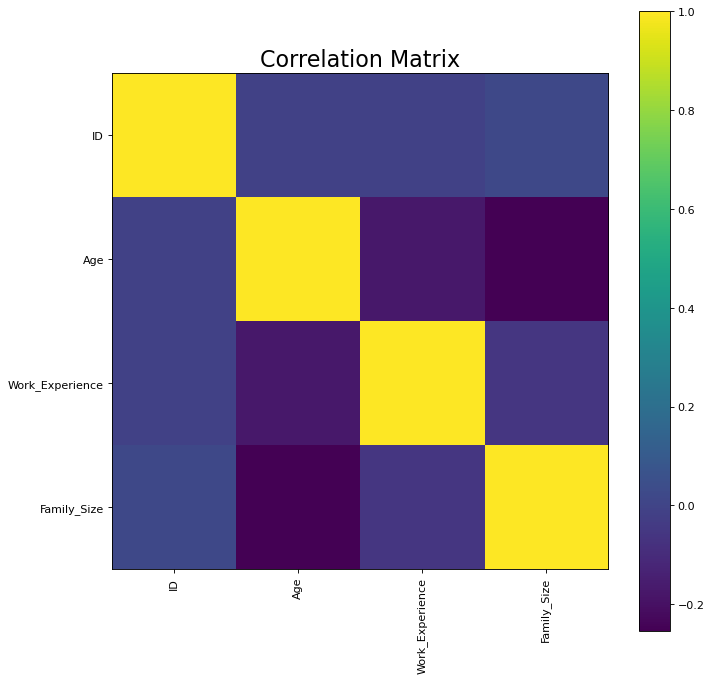

In [ ]:
plotCorrelationMatrix(df, 10)

### Диаграмма рассеяния

Существует встроенная в seaborn функция визуализирующая диаграму рассеяния признаков

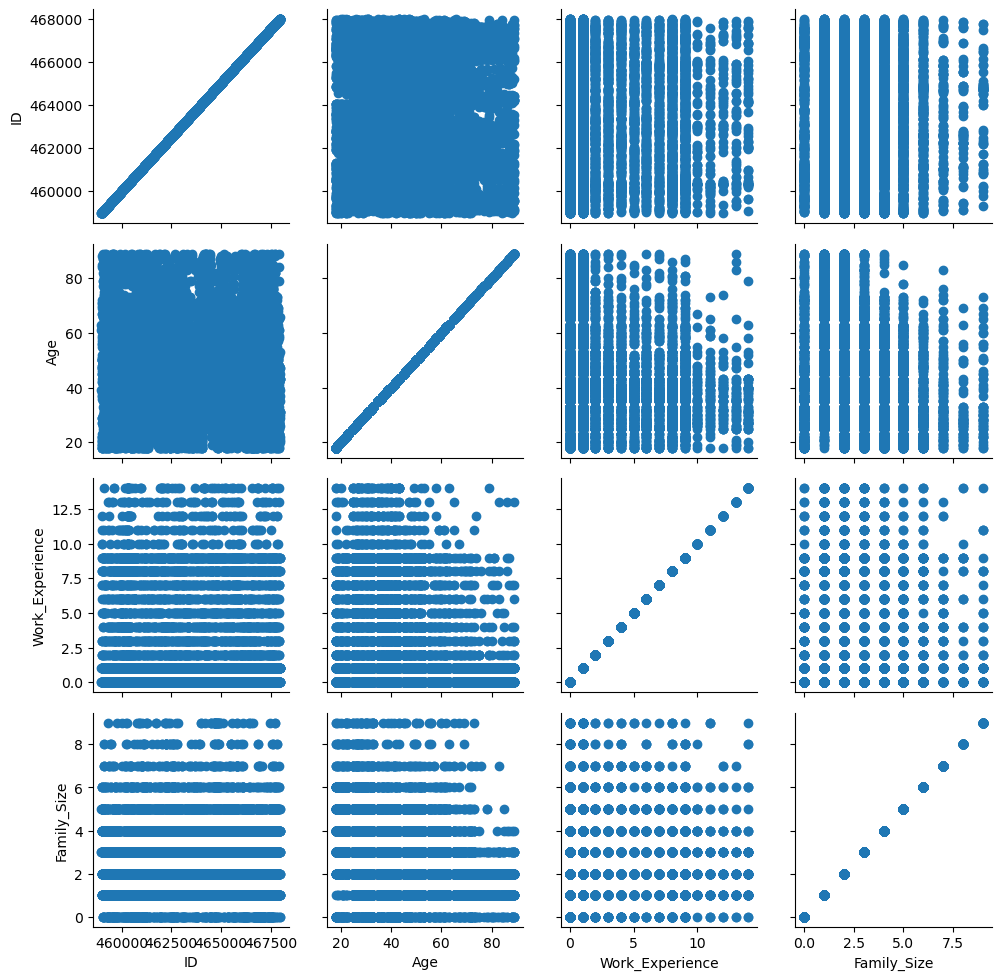

In [ ]:
graph = sns.PairGrid(df) # строим сетку по 2 признакам для каждого столбца таблицы
graph.map(plt.scatter) # строим графики из точек для всех элементов списка
plt.show()

Но также, можно написать и свою собственную функцию

In [ ]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, number_of_columns):
    # оставляем только числовые столбцы
    df = df.select_dtypes(include =[np.number])
    # Удаляем строки и столбцы, которые приведут к сингулярности df
    df = df.dropna('columns')
    # оставляем только те столбцы, в которых более 1 уникального значения
    df = df[[col for col in df if df[col].nunique() > 1]]
    columnNames = list(df)
    # уменьшаем количество столбцов для инверсии матрицы ядерной плотности
    if len(columnNames) > number_of_columns:
        columnNames = columnNames[:number_of_columns]
    df = df[columnNames]
    # строим матрицу диаграмм рассеяния с плотностью
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        # добавляем коэффициенты корреляции на каждый subplot
        ax[i, j].annotate(round(corrs[i, j],3), (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=10)
    # добавляем заголовок
    plt.suptitle(f'Scatter and Density Plot', fontsize=20)
    plt.show()

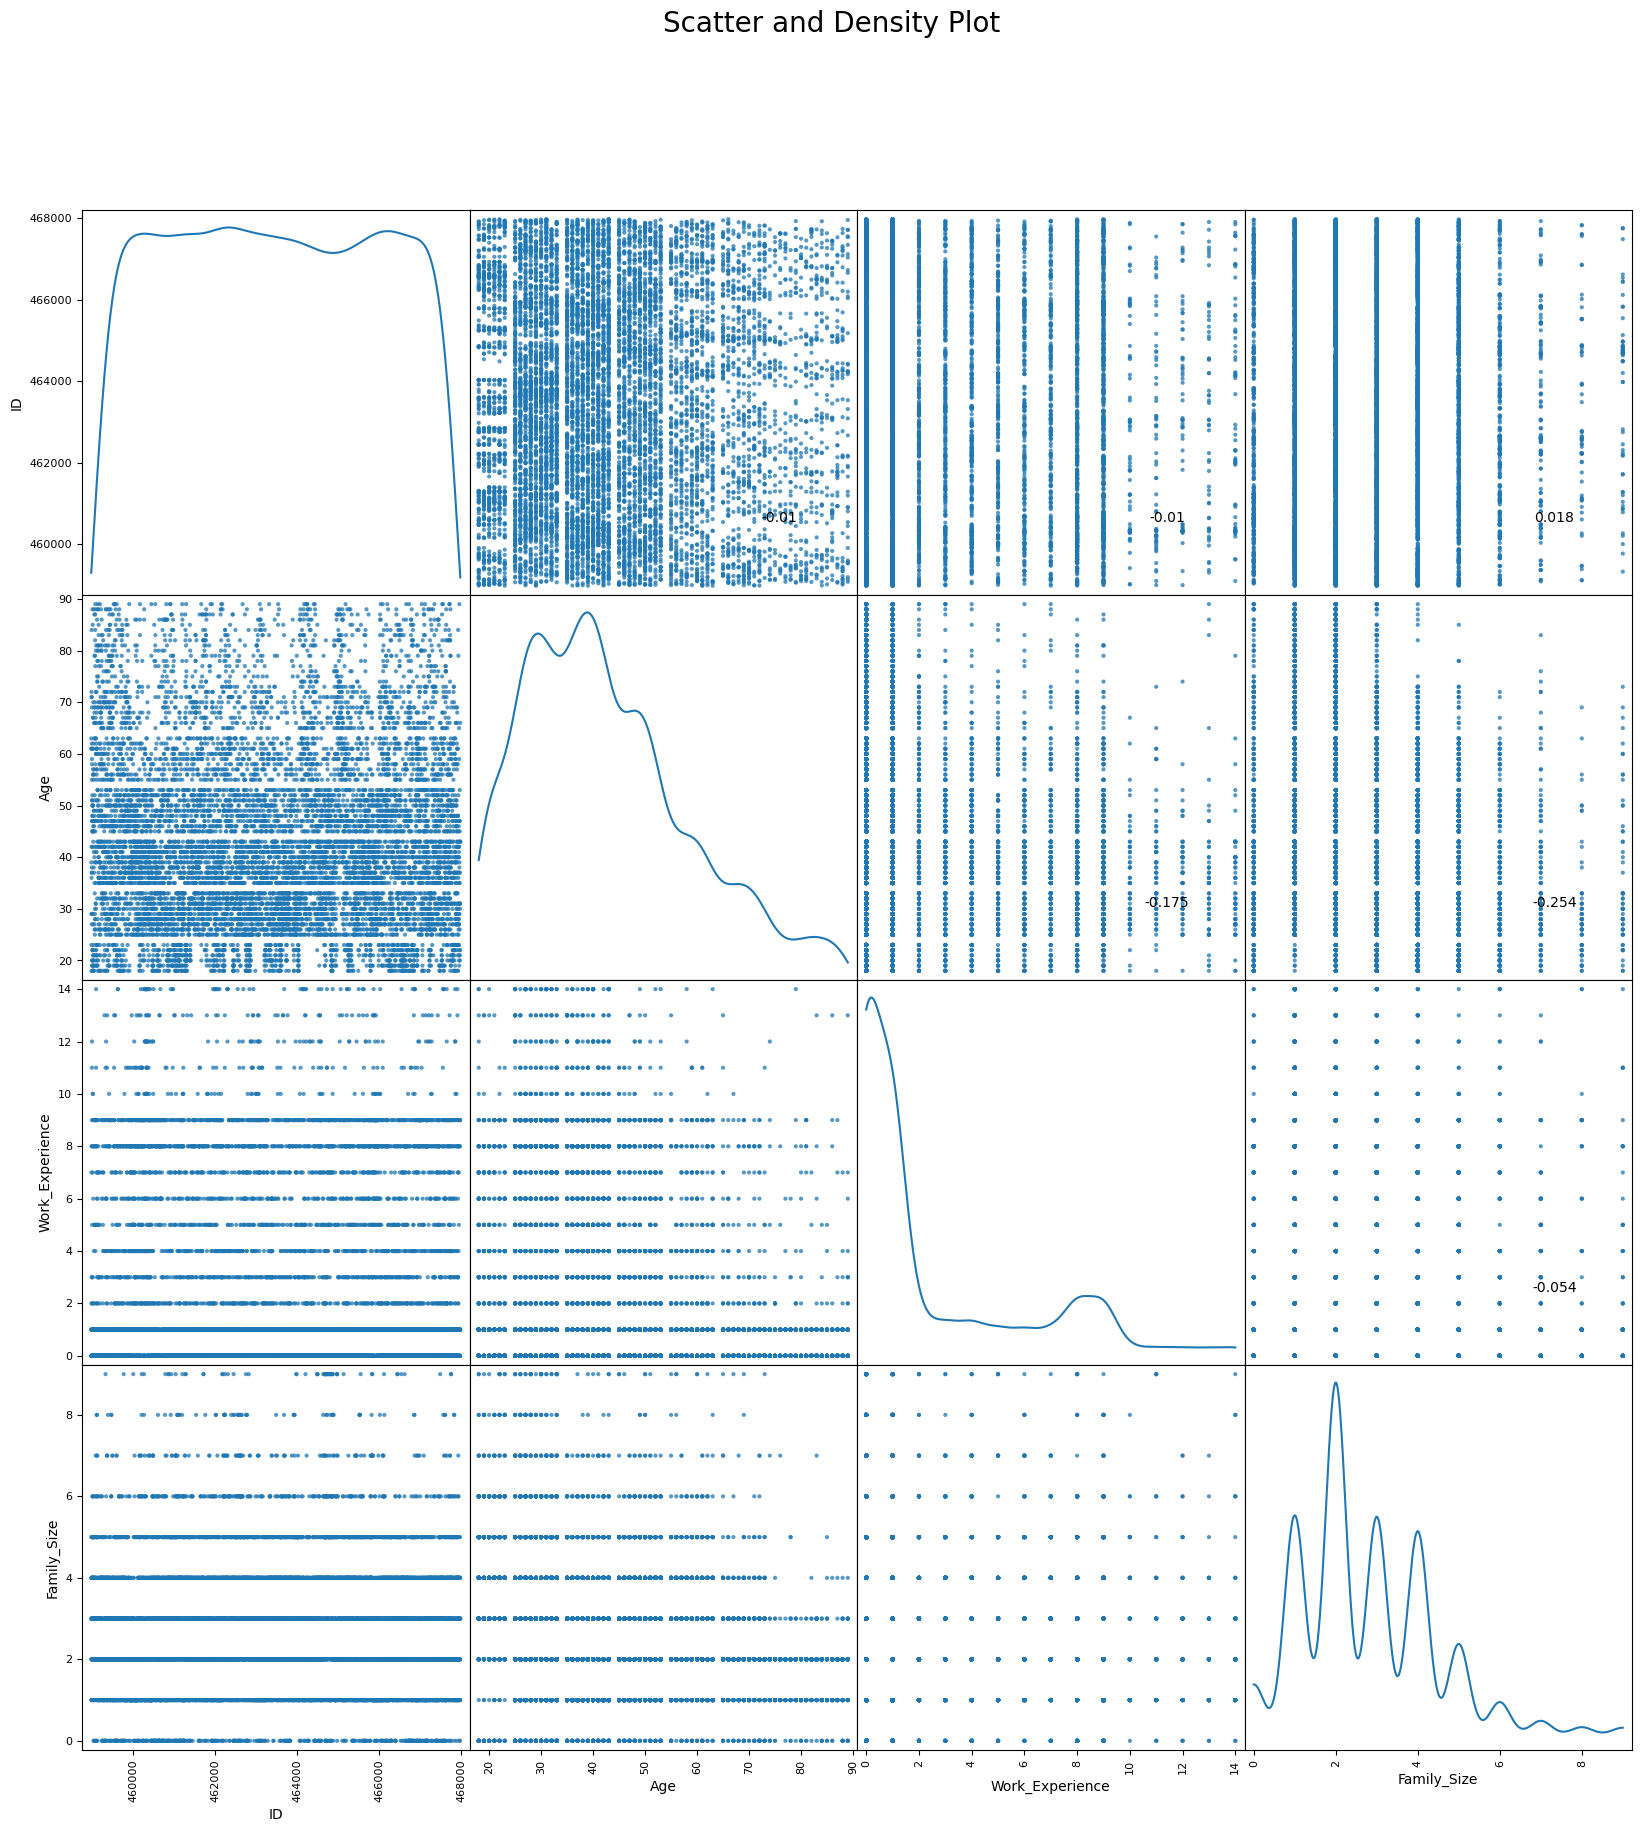

In [ ]:
plotScatterMatrix(df, 20, 10)

# 2. Предобработка данных

### Очистка данных (Data Cleaning)

Удаление отсутствующих значений (NaN), выбросов и дубликатов, исправление опечаток.



#### Удаление дубликатов

In [ ]:
df = df.drop_duplicates()

#### Удаление отсутствующих значений

In [ ]:
df = df.dropna()

### Кодирование категориальных данных (Categorical Data Encoding)

Преобразование категориальных данных (например, типа "город" или "страна") в числовой формат, который может быть использован алгоритмами машинного обучения.



Кодирование категориальных данных - это процесс преобразования категориальных признаков (например, цвет, марка, тип и т.д.) в числовой формат. Это необходимо, так как многие алгоритмы машинного обучения требуют, чтобы все признаки были числовыми. Существует несколько методов кодирования категориальных данных, и вот некоторые из них:

- Label Encoding (Кодирование меток) - это простой метод, который заключается в присвоении каждой уникальной категории целочисленного значения. Например, если у нас есть столбец "цвет" с категориями "красный", "синий" и "зеленый", то "красный" может быть закодирован как 1, "синий" как 2, а "зеленый" как 3.

- One-Hot Encoding (одноразрядное кодирование) - это метод, который создает новые бинарные признаки для каждой уникальной категории. Например, если у нас есть столбец "цвет" с категориями "красный", "синий" и "зеленый", то мы можем создать три новых признака: "цвет_красный", "цвет_синий" и "цвет_зеленый". Если строка содержит категорию "красный", то значение "цвет_красный" будет равно 1, а все остальные значения будут равны 0.

- Binary Encoding (двоичное кодирование) - это метод, который заключается в присвоении каждой уникальной категории целочисленного значения и дальнейшем представлении этого значения в бинарном формате. Например, если у нас есть столбец "цвет" с категориями "красный", "синий" и "зеленый", то "красный" может быть закодирован как 1 (0001 в бинарном формате), "синий" как 2 (0010 в бинарном формате), а "зеленый" как 3 (0100 в бинарном формате).

Кодирование категориальных данных является важной частью предварительной обработки данных в машинном обучении, и выбор метода кодирования зависит от конкретной задачи и характеристик данных.

### Перевод категориальных данных в числовые

In [ ]:
new_df = df.copy()

In [ ]:
print("Gender: ", df['Gender'].unique())
print("Ever_Married: ", df['Ever_Married'].unique())
print("Graduated: ", df['Graduated'].unique())

Gender:  ['Male' 'Female']
Ever_Married:  ['No' 'Yes']
Graduated:  ['No' 'Yes']


In [ ]:
df['Gender'] = df['Gender'].apply(lambda x: 1 if x == 'Male' else 0)
df['Ever_Married'] = df['Ever_Married'].apply(lambda x: 1 if x == 'Yes' else 0)
df['Graduated'] = df['Graduated'].apply(lambda x: 1 if x == 'Yes' else 0)

In [ ]:
df['Spending_Score'].unique()

array(['Low', 'Average', 'High'], dtype=object)

In [ ]:
df['Spending_Score'].replace(to_replace = 'Low', value = 0, inplace = True)
df['Spending_Score'].replace(to_replace = 'Average', value = 1, inplace = True)
df['Spending_Score'].replace(to_replace = 'High', value = 2, inplace = True)

In [ ]:
df['Var_1'].unique()

array(['Cat_4', 'Cat_6', 'Cat_7', 'Cat_3', 'Cat_1', 'Cat_2', 'Cat_5'],
      dtype=object)

In [ ]:
df['Var_1'].replace(to_replace = 'Cat_1', value = 1, inplace = True)
df['Var_1'].replace(to_replace = 'Cat_2', value = 2, inplace = True)
df['Var_1'].replace(to_replace = 'Cat_3', value = 3, inplace = True)
df['Var_1'].replace(to_replace = 'Cat_4', value = 4, inplace = True)
df['Var_1'].replace(to_replace = 'Cat_5', value = 5, inplace = True)
df['Var_1'].replace(to_replace = 'Cat_6', value = 6, inplace = True)
df['Var_1'].replace(to_replace = 'Cat_7', value = 7, inplace = True)

In [ ]:
df['Segmentation'].value_counts()

D    3008
A    2813
C    2434
B    2402
Name: Segmentation, dtype: int64

In [ ]:
df['Segmentation'].replace(to_replace = 'A', value = 0, inplace = True)
df['Segmentation'].replace(to_replace = 'B', value = 1, inplace = True)
df['Segmentation'].replace(to_replace = 'C', value = 2, inplace = True)
df['Segmentation'].replace(to_replace = 'D', value = 3, inplace = True)

In [ ]:
df

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,1,0,22,0,Healthcare,1.0,0,4.0,4,3
1,462643,0,1,38,1,Engineer,0.0,1,3.0,4,0
2,466315,0,1,67,1,Engineer,1.0,0,1.0,6,1
3,461735,1,1,67,1,Lawyer,0.0,2,2.0,6,1
4,462669,0,1,40,1,Entertainment,0.0,2,6.0,6,0
...,...,...,...,...,...,...,...,...,...,...,...
2622,467954,1,0,29,0,Healthcare,9.0,0,4.0,6,1
2623,467958,0,0,35,1,Doctor,1.0,0,1.0,6,0
2624,467960,0,0,53,1,Entertainment,0.0,0,2.0,6,2
2625,467961,1,1,47,1,Executive,1.0,2,5.0,4,2


#### Преобразование категориальных данных в числовой формат

In [ ]:
# from sklearn.preprocessing import LabelEncoder

# label_encoder = LabelEncoder()
# df['A_encoded'] = label_encoder.fit_transform(df['A'])

#### Преобразование категориальных данных в бинарный формат

In [ ]:
new_df.drop(columns=['Segmentation', 'Profession', 'ID'], inplace = True)

In [ ]:
new_df.head()

,Gender,Ever_Married,Age,Graduated,Work_Experience,Spending_Score,Family_Size,Var_1
0,Male,No,22,No,1.0,Low,4.0,Cat_4
1,Female,Yes,38,Yes,0.0,Average,3.0,Cat_4
2,Female,Yes,67,Yes,1.0,Low,1.0,Cat_6
3,Male,Yes,67,Yes,0.0,High,2.0,Cat_6
4,Female,Yes,40,Yes,0.0,High,6.0,Cat_6


In [ ]:
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder()
one_hot_encoded = pd.DataFrame(one_hot_encoder.fit_transform(new_df[['Gender']]).toarray(),
                                columns=one_hot_encoder.get_feature_names(['Gender']))
one_hot_encoded.reset_index(drop=True, inplace=True)
new_df.reset_index(drop=True, inplace=True)
a = pd.concat([new_df, one_hot_encoded], axis=1)

In [ ]:
a

,Gender,Ever_Married,Age,Graduated,Work_Experience,Spending_Score,Family_Size,Var_1,Gender_Female,Gender_Male
0,Male,No,22,No,1.0,Low,4.0,Cat_4,0.0,1.0
1,Female,Yes,38,Yes,0.0,Average,3.0,Cat_4,1.0,0.0
2,Female,Yes,67,Yes,1.0,Low,1.0,Cat_6,1.0,0.0
3,Male,Yes,67,Yes,0.0,High,2.0,Cat_6,0.0,1.0
4,Female,Yes,40,Yes,0.0,High,6.0,Cat_6,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
10652,Male,No,29,No,9.0,Low,4.0,Cat_6,0.0,1.0
10653,Female,No,35,Yes,1.0,Low,1.0,Cat_6,1.0,0.0
10654,Female,No,53,Yes,0.0,Low,2.0,Cat_6,1.0,0.0
10655,Male,Yes,47,Yes,1.0,High,5.0,Cat_4,0.0,1.0


pandas.get_dummies() - функция из библиотеки Pandas, которая создает фиктивные переменные для каждой уникальной категории в столбце категориальных данных. Например, если у нас есть столбец "Цвет", который может содержать значения "Красный", "Зеленый" и "Синий", функция get_dummies() создаст три новых столбца, каждый из которых будет иметь значения 0 или 1 в зависимости от того, какая категория была в исходном столбце.

In [ ]:
new_df = pd.get_dummies(new_df)
new_df

,Age,Work_Experience,Family_Size,Gender_Female,Gender_Male,Ever_Married_No,Ever_Married_Yes,Graduated_No,Graduated_Yes,Spending_Score_Average,Spending_Score_High,Spending_Score_Low,Var_1_Cat_1,Var_1_Cat_2,Var_1_Cat_3,Var_1_Cat_4,Var_1_Cat_5,Var_1_Cat_6,Var_1_Cat_7
0,22,1.0,4.0,0,1,1,0,1,0,0,0,1,0,0,0,1,0,0,0
1,38,0.0,3.0,1,0,0,1,0,1,1,0,0,0,0,0,1,0,0,0
2,67,1.0,1.0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0
3,67,0.0,2.0,0,1,0,1,0,1,0,1,0,0,0,0,0,0,1,0
4,40,0.0,6.0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10652,29,9.0,4.0,0,1,1,0,1,0,0,0,1,0,0,0,0,0,1,0
10653,35,1.0,1.0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0
10654,53,0.0,2.0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0
10655,47,1.0,5.0,0,1,0,1,0,1,0,1,0,0,0,0,1,0,0,0


У нас получилось 2 датафрейма. Один с get_dummies, в другом мы просто заменили значения на численные

### Масштабирование данных (Data Scaling)

Приведение данных к одному масштабу (например, нормализация данных в диапазоне от 0 до 1 или стандартизация данных с нулевым средним и единичной дисперсией).



#### Нормализация данных в диапазоне от 0 до 1

Нормализация - это процесс приведения значений признаков к определенному диапазону. Это полезно, когда значения признаков сильно различаются по масштабу, например, один признак находится в диапазоне [0,1], а другой - в диапазоне [0, 10^5]. В таком случае модель может оказаться менее точной или сильно зависимой от одного из признаков.

Существует несколько методов нормализации:

- Min-max нормализация: каждое значение признака приводится к диапазону [0,1] путем вычитания минимального значения и деления на разность между максимальным и минимальным значениями. Формула: (x - min) / (max - min), где x - значение признака, min - минимальное значение признака, max - максимальное значение признака.

- Z-нормализация (стандартизация): каждое значение признака приводится к стандартному нормальному распределению с нулевым средним и единичной дисперсией. Формула: (x - mean) / std, где x - значение признака, mean - среднее значение признака, std - стандартное отклонение признака.

- Логарифмическая нормализация: каждое значение признака заменяется на его натуральный логарифм. Это может быть полезно, когда значения признаков имеют экспоненциальный рост.

- Другие методы нормализации включают в себя преобразование Бокса-Кокса и Yeo-Johnson.

Выбор метода нормализации зависит от конкретной задачи и типа данных. Некоторые модели, такие как нейронные сети, могут лучше работать с одним методом нормализации, чем с другим.

Нормализация используется в случаях, когда данные имеют различный масштаб и мы хотим, чтобы значения находились в одном и том же диапазоне. Например, это может быть полезно для методов машинного обучения, таких как k-ближайших соседей (k-NN), которые измеряют расстояние между объектами.

In [ ]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# df_normalized = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

In [ ]:
# from sklearn.preprocessing import normalize

# df = normalize(df)

#### Стандартизация данных

Стандартизация данных - это процесс приведения данных к определенному стандарту, который обеспечивает их согласованность и сопоставимость. Это может быть полезно во многих областях, где данные используются для анализа, обработки или хранения.

Одним из наиболее распространенных методов стандартизации данных является центрирование и масштабирование (Z-преобразование). Этот метод заключается в том, чтобы вычесть среднее значение всех значений из каждого значения и затем разделить на стандартное отклонение всех значений. Результатом являются данные со средним значением, равным нулю, и стандартным отклонением, равным единице.

Другой метод стандартизации данных - это мин-макс масштабирование. Этот метод заключается в приведении значений к интервалу между 0 и 1. Для этого каждое значение вычитается из минимального значения в наборе данных и затем делится на разницу между максимальным и минимальным значениями.

Кроме того, стандартизация может включать в себя такие операции, как преобразование типов данных, удаление дубликатов и пропущенных значений, агрегирование данных и приведение их к общей единице измерения.

Стандартизация обычно используется в случаях, когда данные имеют гауссово распределение, и мы хотим, чтобы каждый признак имел ту же дисперсию.

In [ ]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

### Создание новых признаков (Feature Engineering)

Создание новых признаков на основе имеющихся данных, которые могут улучшить производительность модели.



Создание новых признаков на основе имеющихся данных является одним из важных шагов в подготовке данных для обучения модели машинного обучения. Новые признаки могут улучшить производительность модели, сделать ее более точной и улучшить ее способность к обобщению.

Новые признаки могут быть созданы на основе существующих признаков, например, путем объединения нескольких признаков в один или разбиением одного признака на несколько частей. Новые признаки могут также быть созданы на основе внешних данных, которые могут помочь расширить информационное пространство и улучшить способность модели к обобщению.

Примеры создания новых признаков:

- Создание нового признака, который показывает общее количество дней, прошедших с момента последнего визита пользователя на сайт до совершения им покупки.
- Создание нового признака, который описывает отношение площади квартиры к количеству комнат.
- Создание нового признака, который показывает среднюю стоимость товаров, купленных пользователем за последние 6 месяцев.

В целом, создание новых признаков является важным шагом в подготовке данных для машинного обучения, так как позволяет расширить обучающую выборку

In [ ]:
# # создадим новый признак
# data['AB'] = data['A'] + data['B']

### Понижение размерности данных (Dimensionality Reduction)

Снижение количества признаков путем удаления ненужных или коррелирующих признаков или использование методов снижения размерности, таких как метод главных компонент (PCA).




PCA (Principal Component Analysis) - это метод анализа данных, который используется для снижения размерности набора данных путем преобразования его в новый набор переменных, называемый главными компонентами. Главные компоненты являются линейными комбинациями исходных переменных, которые максимизируют объясненную дисперсию данных.

Применение PCA может быть полезным во многих ситуациях, включая снижение размерности набора данных, устранение мультиколлинеарности, ускорение обучения моделей машинного обучения, уменьшение шума и улучшение визуализации данных.

Алгоритм PCA состоит из следующих шагов:

- Вычисление матрицы ковариации для исходного набора данных.
- Расчет собственных значений и собственных векторов матрицы ковариации.
- Сортировка собственных значений в порядке убывания и выбор первых k собственных векторов, соответствующих k самым большим собственным значениям.
- Проекция исходных данных на новое пространство признаков, построенное из выбранных собственных векторов.


In [ ]:
# from sklearn.decomposition import PCA

# # применяем PCA для снижения размерности до двух признаков
# pca = PCA(n_components=2)
# data_raw_pca = pca.fit_transform(data_raw.data)

Понижаем размерность данных с помощью метода главных компонент

In [ ]:
new_df.shape

(10657, 19)

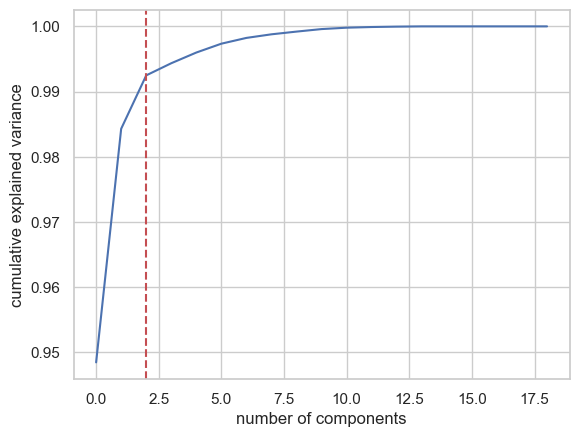

None

,Cumulative Variance Ratio,Explained Variance Ratio
0,0.948439,0.948439
1,0.984287,0.035848
2,0.992480,0.008193
3,0.994344,0.001863
4,0.995986,0.001642
5,0.997344,0.001358
6,0.998230,0.000886
7,0.998782,0.000552
8,0.999198,0.000416
9,0.999585,0.000387


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

pca_test = PCA(n_components=19)
pca_test.fit(new_df)

sns.set(style='whitegrid')
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.axvline(2, color='r', linestyle = '--')
display(plt.show())

evr = pca_test.explained_variance_ratio_
cvr = np.cumsum(pca_test.explained_variance_ratio_)
pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr
display(pca_df.head(10))

воспользуемся PCA для уменьшения числа компонент с 20 до 2

In [ ]:
pca = PCA(n_components=2)
pca.fit(new_df)
new_df_pca = pca.transform(new_df)

In [ ]:
new_df_pca.shape

(10657, 2)

Это преобразование позовляет строить визуализации данных, но при этом упускает часть информации изначальног датасета, поэтому в обучении лучше использовать неизмененную выборку

### Балансировка классов (Class Balancing)

При несбалансированном распределении классов в данных, применяется методы, которые учитывают меньшинство классов.



Балансировка классов - это процесс изменения распределения классов в наборе данных, чтобы сделать его более сбалансированным. Это может быть необходимо, когда в наборе данных присутствуют классы с низкой частотой, которые могут быть необходимы для обучения модели. Без балансировки классов модель может быть смещена в сторону более частых классов, что может привести к плохой производительности на меньшинстве классов.

Существуют различные методы балансировки классов, такие как:

- Undersampling (Снижение размера большего класса) - это метод, который уменьшает размер большего класса, чтобы сделать его более сбалансированным с меньшим классом.

- Oversampling (Увеличение размера меньшего класса) - это метод, который увеличивает размер меньшего класса, чтобы сделать его более сбалансированным с большим классом.

- Synthetic Sampling (Синтетическое дублирование данных меньшего класса) - это метод, который создает новые данные для меньшего класса, чтобы сделать его более сбалансированным с большим классом.

- Class Weighting (Взвешивание классов) - это метод, который вводит веса для каждого класса в функции потерь, чтобы учитывать дисбаланс классов.

In [ ]:
# from imblearn.over_sampling import RandomOverSampler

# ros = RandomOverSampler(random_state=0)
# X_resampled, y_resampled = ros.fit_resample(X, y)


### Разделение данных (Data Splitting)

Разделение данных на тренировочную, валидационную и тестовую выборки.

Разделение данных - это процесс разделения набора данных на обучающую и тестовую выборки для обучения и оценки модели машинного обучения. Обучающая выборка используется для обучения модели, а тестовая выборка используется для проверки ее производительности на новых, ранее не виданных данных.

Обычно данные разделяют в пропорции 70/30, 80/20 или 90/10, где 70%, 80% или 90% данных используется для обучения, а остальные 30%, 20% или 10% данных используются для тестирования.

In [ ]:
y = pd.DataFrame(df['Segmentation'])
y.head()

,Segmentation
0,3
1,0
2,1
3,1
4,0


In [ ]:
x = pd.DataFrame(df[['Gender', 'Ever_Married', 'Age', 'Graduated', 'Work_Experience', 'Spending_Score', 'Family_Size', 'Var_1']])
x.head()

,Gender,Ever_Married,Age,Graduated,Work_Experience,Spending_Score,Family_Size,Var_1
0,1,0,22,0,1.0,0,4.0,4
1,0,1,38,1,0.0,1,3.0,4
2,0,1,67,1,1.0,0,1.0,6
3,1,1,67,1,0.0,2,2.0,6
4,0,1,40,1,0.0,2,6.0,6


In [ ]:
from sklearn.preprocessing import normalize

x = normalize(x)

In [ ]:
from sklearn.model_selection import train_test_split

# Деление на тренировочную и тестовую выборки
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# 3. Обучение моделей

## Классическое машинное обучение

Я взял несколько моделей для сравнения и занес их конечные метрики в единую сводную таблицу.

Формируем пустую сводную таблицу, чтобы потом заполнить ее значениями

In [ ]:
scores = pd.DataFrame(
    columns=['accuracy', 'precision', 'recall', 'f1_score', 'duration'],
    index=[
        'LogisticRegression',
        'SVC linear',
        'SVC gauss',
        'KNeighborsClassifier',
        'MLP',
        'DecisionTree',
        'RandomForest',
        'GradientBoosting',
        'GaussianNB'
    ]
)

Функция для получения метрик качества моделей

In [ ]:
from sklearn import metrics

def get_metrics(y_test, y_pred, average):
    accuracy_score = metrics.accuracy_score(y_test, y_pred)
    precision_score = metrics.precision_score(y_test, y_pred, average=average)
    recall_score = metrics.recall_score(y_test, y_pred, average=average)
    f1_score = metrics.f1_score(y_test, y_pred, average=average)
    return pd.Series(
        (accuracy_score, precision_score, recall_score, f1_score),
        index=['accuracy', 'precision', 'recall', 'f1_score']
    )

Accuracy (точность) - это метрика, которая показывает, как много примеров из тестовой выборки были предсказаны верно. Accuracy определяется как отношение числа правильно классифицированных примеров к общему числу примеров.

$$Accuracy=\frac{TP+TN}{TP+TN+FP+FN}$$

Precision - это метрика качества модели, которая показывает, как часто модель правильно классифицирует положительные примеры. Она определяется как отношение числа верно классифицированных положительных примеров к числу всех примеров, классифицированных как положительные.

$$Precision=\frac{TP}{TP+FP}$$

Recall (полнота) - это метрика, которая оценивает способность модели находить все положительные образцы в наборе данных. Она измеряет, как много релевантных образцов было найдено моделью из общего числа релевантных образцов в наборе данных.

$$Recall=\frac{TP}{TP+FN}$$

F1 score — это среднее гармоническое precision и recall. Это метрика, которая показывает баланс между precision и recall и является хорошим индикатором для оценки качества модели.

F1 score дает более точную информацию о качестве модели, чем accuracy, если в данных присутствует дисбаланс классов. Если, например, один класс присутствует в данных гораздо чаще, чем другой класс, то accuracy может быть высокой, даже если модель классифицирует хуже для редкого класса. В такой ситуации более информативными могут быть precision, recall и F1 score.

F1 score принимает значения в диапазоне от 0 до 1, где 1 — это идеальное значение, которое означает, что модель работает наилучшим образом, а 0 — это худшее значение, которое означает, что модель не предсказывает ни один из классов.

$$F1 score = \frac{2*Precision*Recall}{Precision+Recall}$$

Функция обучения и записи времени процесса обучения модели в секундах

In [ ]:
import time
from sklearn import metrics
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import plot_precision_recall_curve
import scikitplot as skplt

def model_and_metrics(model, average="weighted"):

    # начало обучения модели
    start = time.time()
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    # конец обучения модели
    end = time.time()

    # Построение графика precision_recall
    skplt.metrics.plot_precision_recall_curve(y_test, model.predict_proba(x_test))
    plt.show()

    duration = pd.Series([end - start])
    returned = pd.concat([get_metrics(y_test, y_pred, average=average), duration])
    return returned

График precision-recall curve (кривая точности-полноты) используется для оценки качества бинарной классификации. Он показывает зависимость точности (precision) от полноты (recall) при изменении порога классификации.

Кривая precision-recall представляет собой кривую, проходящую через точки, где каждая точка соответствует определенному значению порога классификации. Чем ближе точка к верхнему правому углу графика, тем выше качество классификатора. Также на графике может быть отмечен порог классификации, при котором достигается наилучшее качество.

ROC-кривая (Receiver Operating Characteristic curve) - это график, который показывает качество бинарной классификации на разных уровнях порога (threshold). Он отображает отношение между положительными верно классифицированными объектами (true positive rate, TPR) и ложными положительными решениями (false positive rate, FPR).

FPR - это доля неправильно классифицированных отрицательных примеров (то есть, количество ложных положительных ответов относительно общего количества отрицательных примеров). TPR - это доля правильно классифицированных положительных примеров (то есть, количество правильно положительных ответов относительно общего количества положительных примеров).

ROC-кривая представляет собой кривую, проходящую через точки с координатами (FPR, TPR) при различных уровнях порога. Она может быть использована для определения наилучшего порога для модели, который максимизирует TPR и минимизирует FPR.

ROC-кривая может быть оценена с помощью метрики AUC-ROC (Area Under the ROC Curve), которая представляет собой площадь, ограниченную ROC-кривой и осью y=x. Значение AUC-ROC может быть интерпретировано как вероятность того, что модель правильно укажет, какой из двух объектов (положительный или отрицательный) имеет более высокую вероятность.

### #1 Classic model (LogisticRegression)

Logistic Regression - это алгоритм машинного обучения, который используется для решения задач классификации, т.е. для разделения данных на категории или классы.

Логистическая регрессия основывается на функции логистической сигмоиды, которая преобразует линейный входной сигнал в вероятность. То есть, логистическая регрессия представляет собой обучение модели, которая использует линейную комбинацию входных признаков для прогнозирования вероятности отнесения объекта к одному из двух классов.

Модель логистической регрессии обучается с помощью метода максимального правдоподобия, который позволяет найти наилучшие значения параметров модели, максимизирующие вероятность наблюдаемых данных.

В логистической регрессии используется также регуляризация, которая помогает бороться с переобучением модели.

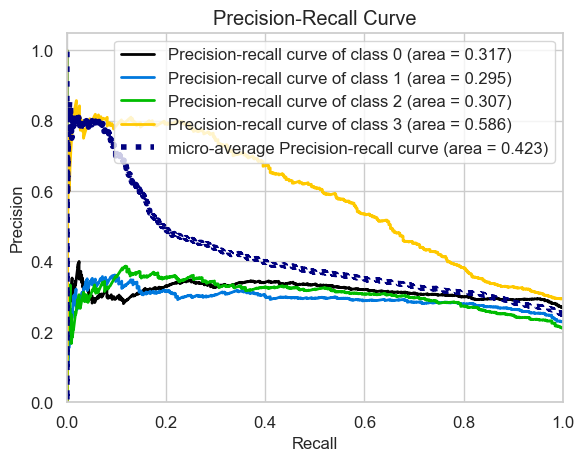

In [ ]:
from sklearn.linear_model import LogisticRegression

scores.iloc[0] = model_and_metrics(LogisticRegression(multi_class='multinomial')) #max_iter=1000

### #2 Classic model (SVM.linear)

SVM - это метод машинного обучения, который использует гиперплоскость для разделения классов в многомерном пространстве. Линейное ядро в SVM представляет собой обычную линейную функцию, которая стремится разделить классы на две группы с помощью гиперплоскости в пространстве признаков.

Модель svm.SVC(kernel='linear') подходит для задач классификации с двумя классами и может использоваться для разделения данных с линейно разделимыми классами. Обучение модели происходит путем поиска гиперплоскости, которая разделяет классы наиболее точно. SVM поддерживает не только линейные ядра, но также может использовать ядра с нелинейными функциями, такие как полиномиальные и радиально-базисные функции.

Для обучения модели SVM c линейным ядром используется метод оптимизации под названием Sequential Minimal Optimization (SMO), который является быстрым и эффективным методом для решения оптимизационной задачи SVM.

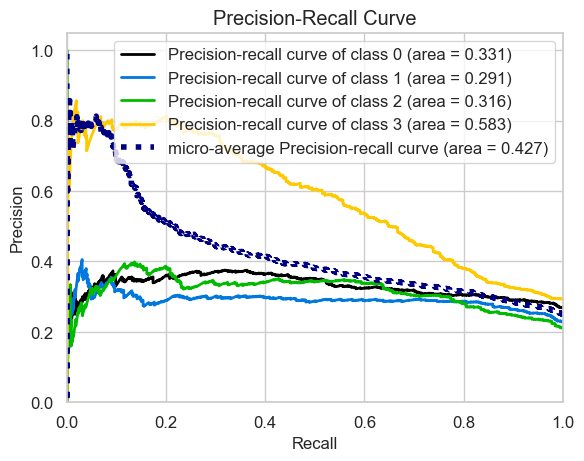

In [ ]:
from sklearn import svm

scores.iloc[1] = model_and_metrics(svm.SVC(kernel='linear', probability=True))

### #3 Classic model (SVM.rbf)

RBF-ядро является одним из наиболее популярных ядер, используемых в SVM для обработки нелинейных данных.

Суть работы алгоритма SVM с ядром RBF заключается в следующем:

- Выбрать оптимальные параметры ядра RBF.
- Обучить классификатор SVM на обучающих данных.
- Применить обученный классификатор SVM к новым данным для классификации.

Классификатор SVM с ядром RBF является более гибким по сравнению с классификатором SVM с линейным ядром, так как позволяет лучше разделить нелинейные данные. Однако, он имеет больше параметров, которые нужно настроить для достижения лучшей производительности модели. Также, в отличие от линейного ядра, классификатор с RBF-ядром склонен к переобучению на небольших выборках данных.

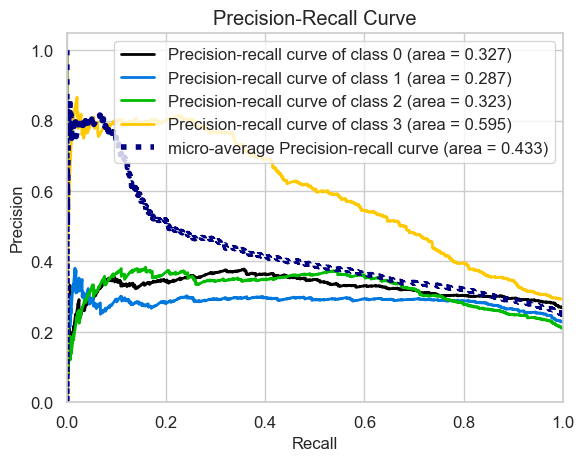

In [ ]:
from sklearn import svm

scores.iloc[2] = model_and_metrics(svm.SVC(kernel='rbf', probability=True))

### #4 Classic model (KNeighborsClassifier)

KNeighborsClassifier - это алгоритм классификации, который основывается на определении класса объекта путем анализа классов его ближайших соседей в пространстве признаков.

В данном алгоритме объекты сравниваются на основе расстояния между ними в пространстве признаков. Определяется k ближайших соседей для каждого объекта, после чего класс объекта определяется на основе классов его соседей. Обычно для вычисления расстояний между объектами используется евклидово расстояние, однако возможно использование и других метрик.

Количество соседей k - это один из гиперпараметров модели, который определяется заранее. Если k=1, то классификация объекта производится на основе класса его ближайшего соседа. Если k>1, то классификация производится путем голосования за наиболее часто встречающийся класс среди k ближайших соседей.

Кроме того, для работы модели необходимо выбрать метрику расстояния и метод взвешивания расстояний.

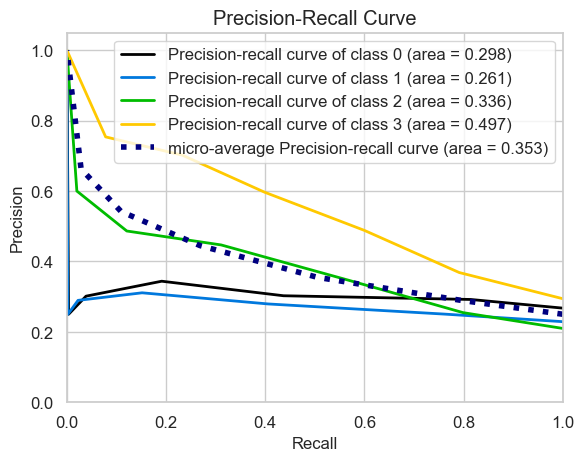

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

scores.iloc[3] = model_and_metrics(KNeighborsClassifier(n_neighbors=5, weights='uniform'))

### #5 Classic model (MLPClassifier)

MLPClassifier - это алгоритм машинного обучения, который относится к семейству нейронных сетей. Он использует многослойную перцептронную модель, которая состоит из нескольких скрытых слоев, каждый из которых содержит набор нейронов. MLPClassifier используется для задач классификации, то есть он пытается определить, к какому классу относится входной образец данных.

Основная идея MLPClassifier заключается в том, чтобы обучать модель путем подачи обучающих примеров на вход нейронной сети и последующей корректировки весов между нейронами. Это происходит через процесс обратного распространения ошибки (backpropagation), в котором модель сначала делает предсказание, затем оценивает, насколько оно верно, и корректирует веса, чтобы улучшить предсказания на следующей итерации.

MLPClassifier позволяет настраивать множество параметров, включая количество скрытых слоев, количество нейронов в каждом слое, тип функции активации, метод оптимизации и т.д. Одним из главных параметров MLPClassifier является alpha, который контролирует уровень регуляризации. Большие значения alpha могут привести к уменьшению переобучения модели, но также могут снизить ее общую точность.

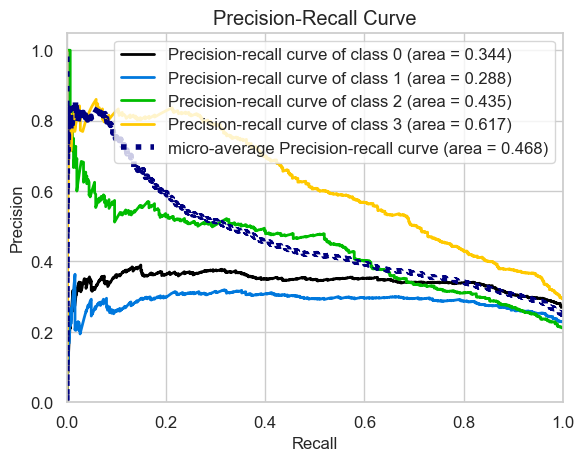

In [ ]:
from sklearn.neural_network import MLPClassifier

scores.iloc[4] = model_and_metrics(MLPClassifier())

### #6 Classic model (DecisionTree)

DecisionTree (Дерево решений) - это один из наиболее популярных методов машинного обучения для задач классификации и регрессии. Он является примером обучения с учителем и используется для построения модели прогнозирования на основе множества правил.

Принцип работы алгоритма заключается в разбиении исходного набора данных на более мелкие поднаборы, путем построения древовидной структуры, где каждый узел дерева представляет собой условие на одном из признаков, а каждое ребро - возможный результат теста. Древо строится снизу вверх, начиная с корневого узла, где разбиение основано на наиболее значимом признаке, и продолжается до тех пор, пока не будет достигнут критерий остановки, например, достижение максимальной глубины или минимального количества объектов в листе.

После построения дерева, каждый объект классифицируется путем прохождения по нему, начиная с корневого узла и двигаясь вниз по ребрам до достижения листового узла. Классификация происходит на основе меток классов в листовом узле.

Одним из преимуществ DecisionTree является его интерпретируемость, что означает возможность легкого понимания результата, полученного моделью. Также DecisionTree устойчив к выбросам и нечувствителен к масштабированию признаков.

Однако, как и у любой модели машинного обучения, есть и недостатки. DecisionTree склонен к переобучению на больших датасетах и может давать плохие результаты на данных, которые не были представлены во время обучения модели.

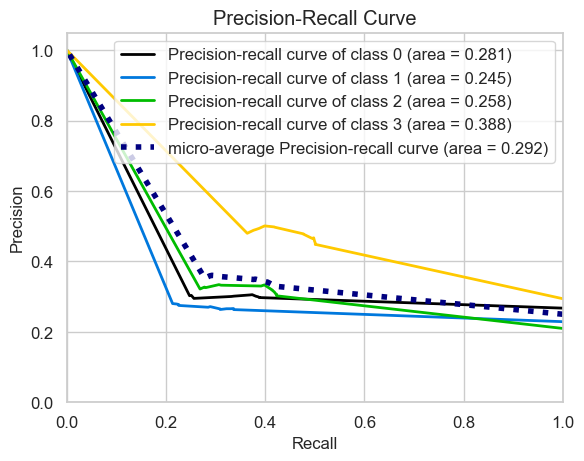

In [ ]:
from sklearn.tree import DecisionTreeClassifier

scores.iloc[5] = model_and_metrics(DecisionTreeClassifier())

### #7 Classic model (RandomForest)

Random Forest (случайный лес) - это алгоритм машинного обучения, который использует ансамбль решающих деревьев для решения задач классификации, регрессии и кластеризации. Он является одним из наиболее популярных алгоритмов машинного обучения и широко используется в различных областях, включая банкинг, финансы, медицину, науку о данных и другие.

Случайный лес состоит из множества решающих деревьев, каждое из которых строится на основе случайной подвыборки данных. Это позволяет уменьшить вероятность переобучения и повысить качество предсказаний. Кроме того, случайный лес позволяет оценить важность признаков, что может быть полезно при анализе данных.

Для построения случайного леса сначала выбирается количество деревьев, которые должны быть включены в ансамбль. Затем для каждого дерева выбирается случайная подвыборка данных и случайный поднабор признаков. Затем строится дерево решений, которое оптимизируется на основе выбранного критерия (например, энтропии или Джини). Критерий оценивает, насколько хорошо каждый признак разделяет данные на классы или прогнозирует значение.

После построения всех деревьев случайный лес может использоваться для предсказания новых данных. Для каждого дерева происходит предсказание, затем выбирается наиболее часто встречающийся класс или среднее значение, и это становится итоговым предсказанием.

Случайный лес имеет несколько преимуществ по сравнению с одним решающим деревом, включая более точные предсказания и устойчивость к шумам в данных. Кроме того, случайный лес хорошо работает с большими объемами данных и может обрабатывать как числовые, так и категориальные признаки.

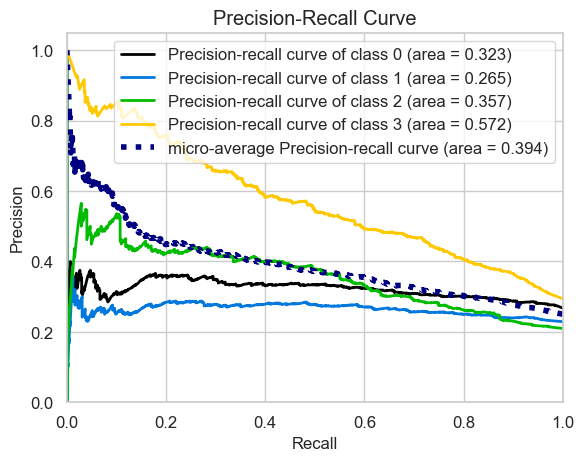

In [ ]:
from sklearn.ensemble import RandomForestClassifier

scores.iloc[6] = model_and_metrics(RandomForestClassifier())

### #8 Classic model (GradientBoosting)

Gradient Boosting (GB) - это метод машинного обучения, который основан на построении ансамбля (ensemble) слабых моделей, как правило, деревьев решений. Основная идея GB заключается в том, чтобы последовательно строить новые модели, которые будут исправлять ошибки предыдущих моделей. Таким образом, каждая новая модель учитывает ошибки предыдущих моделей, и все модели образуют сильную модель.

Алгоритм GB работает следующим образом:

Сначала мы создаем модель, которая делает предсказания на основе среднего значения целевой переменной в тренировочных данных.

Затем мы строим следующую модель, используя реальные значения целевой переменной и ошибки предыдущей модели.

Новая модель старается исправить ошибки предыдущей модели.

Мы продолжаем строить новые модели и добавлять их к ансамблю до тех пор, пока не достигнем установленного числа деревьев.

Основными параметрами GB являются:

learning rate (шаг обучения), который определяет величину обновления весов на каждой итерации.

число деревьев (n_estimators), которые будут использоваться для построения ансамбля.

максимальная глубина дерева (max_depth), которая определяет глубину дерева решений.

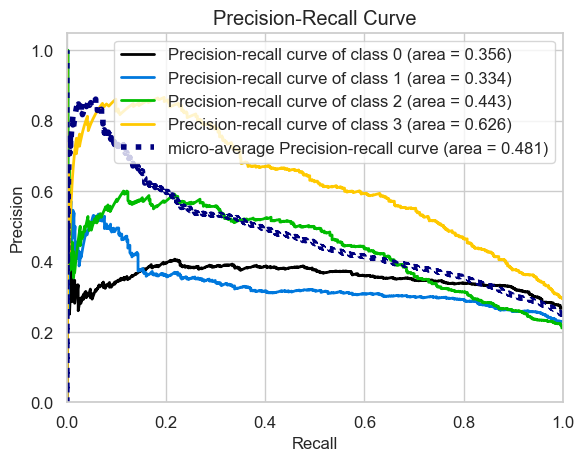

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

scores.iloc[7] = model_and_metrics(GradientBoostingClassifier())

### #9 Classic model (GaussianNB)

Gaussian Naive Bayes (GNB) - это вероятностный алгоритм классификации, основанный на теореме Байеса и условии независимости. Этот алгоритм предполагает, что значения каждого признака в каждом классе имеют гауссово распределение. GNB использует эти распределения, чтобы оценить вероятность того, что объект принадлежит к определенному классу. Затем он выбирает класс с максимальной вероятностью как прогноз.

Главное преимущество GNB заключается в его простоте и скорости работы. Этот алгоритм работает хорошо на наборах данных с множеством признаков, но может давать плохие результаты, если признаки сильно коррелируют между собой. Кроме того, GNB не учитывает взаимодействия между признаками и не может захватывать нелинейные зависимости между признаками и целевой переменной.

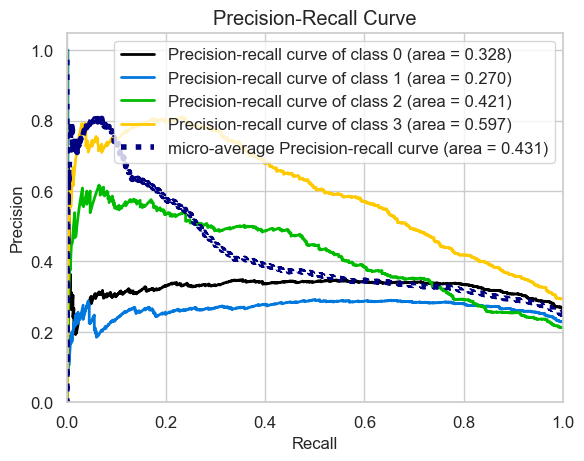

In [ ]:
from sklearn.naive_bayes import GaussianNB

scores.iloc[8] = model_and_metrics(GaussianNB())

### Анализ процесса обучения

Смотрим резултаты сводной таблицы и сравниваем модели по метрикам качества

In [ ]:
scores

,accuracy,precision,recall,f1_score,duration
LogisticRegression,0.403377,0.37038,0.403377,0.358401,0.368021
SVC linear,0.364916,0.253462,0.364916,0.274404,26.374619
SVC gauss,0.399625,0.339864,0.399625,0.354852,44.337265
KNeighborsClassifier,0.375704,0.393637,0.375704,0.380734,0.119003
MLP,0.439493,0.426562,0.439493,0.412671,6.43405
DecisionTree,0.351313,0.359787,0.351313,0.35412,0.064998
RandomForest,0.394934,0.39159,0.394934,0.392659,1.617062
GradientBoosting,0.460131,0.451731,0.460131,0.451886,6.226101
GaussianNB,0.391182,0.394089,0.391182,0.366457,0.004001


Из предоставленных данных оценки метрик качества и времени выполнения моделей, можно сделать следующие выводы:

1. Самая эффективная модель: GradientBoosting. Она показывает наивысшую точность (accuracy - 0.4606), высокие значения precision, recall и F1-меры, что указывает на хорошую способность модели правильно классифицировать данные. Кроме того, время выполнения (duration) для этой модели составляет 5.926124, что является приемлемым с учетом ее высокой производительности.

2. Самая быстрая модель: GaussianNB. Время выполнения для этой модели составляет всего 0.004998, что является самым низким значением среди всех моделей. Однако, стоит отметить, что точность (accuracy) и другие метрики для GaussianNB немного ниже по сравнению с другими моделями. Таким образом, если скорость выполнения является критически важным фактором, то GaussianNB может быть подходящим выбором.

3. Самая точная модель: GradientBoosting. Как уже упоминалось ранее, модель GradientBoosting показывает наивысшую точность (accuracy - 0.4606). Она обладает хорошей способностью правильно классифицировать данные и достигает более высоких значений precision, recall и F1-меры по сравнению с другими моделями.

В целом, модель GradientBoosting является наиболее эффективной и точной среди представленных моделей, однако она также требует больше времени для выполнения. Если скорость выполнения является приоритетом, можно рассмотреть использование модели GaussianNB, хотя при этом наблюдается некоторое снижение точности. Выбор модели должен зависеть от конкретных требований проекта и баланса между точностью и временем выполнения.

## Нейронные сети

### #1 Neural model (CNN)

Для примера модели классификации мы будем использовать наиболее распространенную модель Сверточной нейронной сети. В нее можно включить большое число слоев, но чаще всего строится 3 слоя, так мы и поступим

CNN (Convolutional Neural Network) - это класс нейронных сетей, разработанных для обработки данных с несколькими измерениями, такими как изображения.

Основной идеей CNN является использование свертки (convolution) в качестве основного оператора для извлечения признаков из входных данных. Этот процесс сравнивает небольшие участки входных данных с фильтрами (kernels) свертки, чтобы создать карту признаков (feature map). Затем, используя операцию субдискретизации (subsampling) или пулинга (pooling), размерность карты признаков уменьшается, сохраняя при этом наиболее важные признаки.

CNN обычно состоит из трех типов слоев: сверточные (convolutional), слои субдискретизации (subsampling) или пулинга (pooling), а также полносвязные (fully-connected) слои. Сверточные слои извлекают признаки из входных данных, слои субдискретизации снижают размерность карты признаков, а полносвязные слои преобразуют карту признаков в выходные данные.

CNN успешно используется для классификации изображений, распознавания образов, распознавания речи, обработки естественного языка и других задач машинного обучения.

Create Custom CNN Model

In [ ]:
# conda install cudatoolkit

In [ ]:
# pip install torch

In [ ]:
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y.values)
        self.n_samples = self.X.size(0)

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [ ]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(in_features=8, out_features=16),
            nn.Sigmoid(),
            nn.Linear(in_features=16, out_features=4)
        )

    def forward(self, x):
        x = self.fc(x)
        return x

In [ ]:
# model = nn.Sequential(
#     nn.Linear(in_features=9, out_features=50),
#     nn.ReLU(),
#     nn.Linear(in_features=50, out_features=1)
# )

In [ ]:
train_set = MyDataset(x_train, y_train)
test_set = MyDataset(x_test, y_test)

train_dataloader = DataLoader(train_set, batch_size=4)
test_dataloader = DataLoader(test_set, batch_size=1000)

model = MyModel()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# optimizer = optim.Adam(model.parameters(), lr=0.1)
criterion = nn.MultiMarginLoss()
# y_pred = y_pred.argmax()

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

In [ ]:
accuracy_s = []
precision_s = []
recall_s = []
f1_s = []

In [ ]:
for epoch in range(10):
    model.train()
    for x, y in train_dataloader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y.squeeze().long())
        loss.backward()
        optimizer.step()
    y_trues = torch.empty(0)
    y_predicts = torch.empty(0)
    model.eval()
    with torch.no_grad():
        for x, y in test_dataloader:
            x, y = x.to(device), y.to(device)
            y_trues = torch.cat((y_trues, y))
            y_predicts = torch.cat((y_trues, y))
            y_pred = model(x)
            y_pred = y_pred.argmax(dim=1).cpu().numpy()
        accuracy = accuracy_score(y_pred, y.cpu())
        precision = precision_score(y_pred, y.cpu(), average='weighted')
        recall = recall_score(y_pred, y.cpu(), average='weighted')
        f1 = f1_score(y_pred, y.cpu(), average='weighted')

        if epoch % 2 == 0:
            print(accuracy.item())
            accuracy_s.append(accuracy.item())
            precision_s.append(precision.item())
            recall_s.append(recall.item())
            f1_s.append(f1.item())

0.38636363636363635
0.25
0.32575757575757575
0.36363636363636365
0.3939393939393939


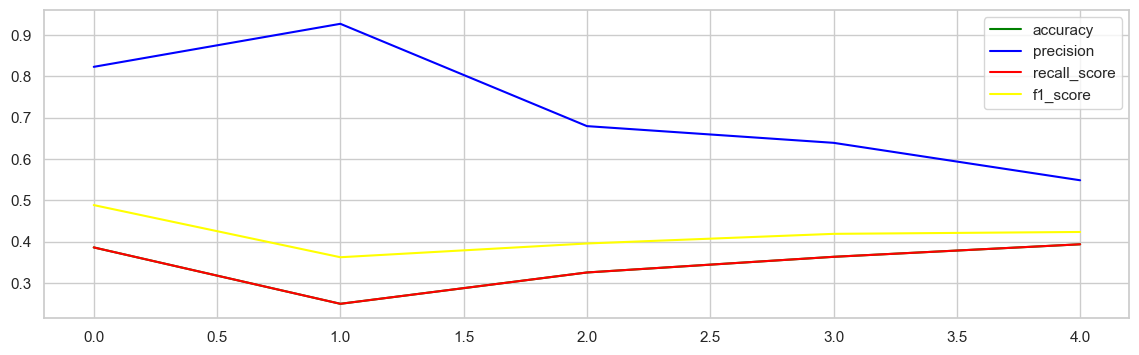

In [ ]:
plt.figure(figsize=(14,4))
plt.plot(accuracy_s, color='green')
plt.plot(precision_s, color='blue')
plt.plot(recall_s, color='red')
plt.plot(f1_s, color='yellow')
plt.legend (('accuracy', 'precision', 'recall_score', 'f1_score'))
plt.show();

In [ ]:
y_predicts.shape

torch.Size([2264, 1])

In [ ]:
y_test.shape

(2132, 1)

In [ ]:
model.eval()
x, y = next(iter(test_dataloader))
y_pred = model(x).cpu().detach().numpy()

In [ ]:
neuaral_scores = pd.DataFrame(
    columns=['accuracy', 'precision', 'recall', 'f1_score'],
    index=['neural_network']
)
neuaral_scores.iloc[0] = pd.Series(
        (round(accuracy_s[-1], 4), round(precision_s[-1], 4), round(recall_s[-1], 4), round(f1_s[-1], 4)),
        index=['accuracy', 'precision', 'recall', 'f1_score']
    )
neuaral_scores

,accuracy,precision,recall,f1_score
neural_network,0.3939,0.5488,0.3939,0.4237


# Вывод

Классические модели обучения и нейронные сети имеют свои преимущества и недостатки, и выбор определенной модели зависит от многих факторов, таких как задача, данные, вычислительные ресурсы, опыт разработчика и т.д.

Классические модели обучения, такие как логистическая регрессия, решающие деревья, случайный лес, метод опорных векторов и т.д., могут быть эффективными для решения задач с малым количеством данных или небольшим количеством признаков, а также для задач, где интерпретируемость модели является важным фактором. Классические модели могут быть более легкими в обучении и требовать меньшего количества вычислительных ресурсов, чем нейронные сети.

С другой стороны, нейронные сети могут быть более эффективными для решения задач, где имеется большой объем данных или большое количество признаков. Они могут быть лучшим выбором для задач компьютерного зрения, обработки естественного языка и рекомендательных систем. Нейронные сети могут обнаруживать сложные нелинейные зависимости между признаками и выявлять скрытые паттерны в данных, что делает их особенно полезными для задач, где нет явных правил или определенной структуры данных.

Эта работа еще раз доказывает то, что на больших наборах данных нейронные сети справляются гораздо лучше, чем любая классическая модель обучения. В данном случае CNN показала себя лучше, чем MLP, потому что вторая переобучилась и показывает некорректные значения.

# Tensorflow

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [ ]:
# Создание модели нейронной сети
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(8,)))
model.add(Dense(32, activation='relu'))
model.add(Dense(4, activation='softmax'))

# Компиляция модели
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Обучение модели на тренировочных данных
model.fit(x_train, y_train, epochs=20, batch_size=16, validation_data=(x_test, y_test))

# Оценка модели на тестовых данных
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)
accuracy = model.evaluate(x_test, y_test)[1]

Epoch 1/20
533/533 [==============================] - 2s 3ms/step - loss: 1.3498 - accuracy: 0.3188 - val_loss: 1.2971 - val_accuracy: 0.3640
Epoch 2/20
533/533 [==============================] - 1s 2ms/step - loss: 1.2969 - accuracy: 0.3735 - val_loss: 1.2787 - val_accuracy: 0.3935
Epoch 3/20
533/533 [==============================] - 1s 2ms/step - loss: 1.2869 - accuracy: 0.3853 - val_loss: 1.2804 - val_accuracy: 0.3921
Epoch 4/20
533/533 [==============================] - 1s 2ms/step - loss: 1.2810 - accuracy: 0.3973 - val_loss: 1.2693 - val_accuracy: 0.4142
Epoch 5/20
533/533 [==============================] - 1s 2ms/step - loss: 1.2763 - accuracy: 0.4050 - val_loss: 1.2617 - val_accuracy: 0.4006
Epoch 6/20
533/533 [==============================] - 1s 2ms/step - loss: 1.2720 - accuracy: 0.4075 - val_loss: 1.2596 - val_accuracy: 0.4114
Epoch 7/20
533/533 [==============================] - 1s 2ms/step - loss: 1.2689 - accuracy: 0.4075 - val_loss: 1.2552 - val_accuracy: 0.4179
Epoch 

Accuracy: 0.4244840443134308
Confusion Matrix:
[[269  16 170 115]
 [178  16 234  60]
 [101  12 282  52]
 [192  11  86 338]]
Classification Report:
              precision    recall  f1-score   support

           0       0.36      0.47      0.41       570
           1       0.29      0.03      0.06       488
           2       0.37      0.63      0.46       447
           3       0.60      0.54      0.57       627

    accuracy                           0.42      2132
   macro avg       0.40      0.42      0.37      2132
weighted avg       0.42      0.42      0.39      2132



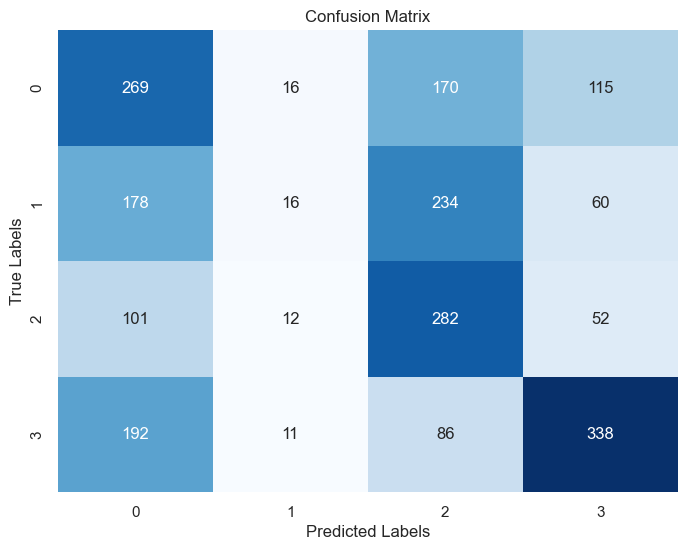

In [ ]:
# Вывод метрик качества
print("Accuracy:", accuracy)
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Визуализация матрицы ошибок
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


# Selection of Hyperparameters

In [ ]:
# pip install keras-tuner

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow import keras
import tensorflow.keras.metrics as metrics
import kerastuner as kt

In [ ]:
# Создание модели нейронной сети
def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units', min_value=32, max_value=128, step=32), activation='relu', input_shape=(8,)))
    model.add(Dense(units=hp.Int('units', min_value=32, max_value=128, step=32), activation='relu'))
    model.add(Dense(units=4, activation='softmax'))
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Создание объекта для подбора гиперпараметров
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    directory='.',
    project_name='hyperparameter_tuning'
)

# Поиск оптимальных гиперпараметров
tuner.search(x_train, y_train, epochs=50, validation_data=(x_test, y_test))

# Получение лучшей модели и ее параметров
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters: ", best_hyperparameters)

# Обучение модели с лучшими гиперпараметрами
best_model.fit(x_train, y_train, epochs=50, validation_data=(x_test, y_test))

# Оценка модели на тестовых данных
y_pred_probs = best_model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)
accuracy = best_model.evaluate(x_test, y_test)[1]

INFO:tensorflow:Reloading Tuner from .\hyperparameter_tuning\tuner0.json
INFO:tensorflow:Oracle triggered exit
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                576       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 4)                 260       
                                                                 
Total params: 4,996
Trainable params: 4,996
Non-trainable params: 0
_________________________________________________________________
Best Hyperparameters:  <keras_tuner.engine.hyperparameters.hyperparameters.HyperParameters object at 0x000001DE8401C6A0>
Epoch 1/50
267/267 [==============================] - 1s 3ms/step - loss: 1.2231 - acc

67/67 [==============================] - 0s 2ms/step - loss: 1.2458 - accuracy: 0.4428


Accuracy: 0.44277673959732056
Confusion Matrix:
[[222 139  73 136]
 [144 127 140  77]
 [ 83  96 215  53]
 [157  58  32 380]]
Classification Report:
              precision    recall  f1-score   support

           0       0.37      0.39      0.38       570
           1       0.30      0.26      0.28       488
           2       0.47      0.48      0.47       447
           3       0.59      0.61      0.60       627

    accuracy                           0.44      2132
   macro avg       0.43      0.43      0.43      2132
weighted avg       0.44      0.44      0.44      2132



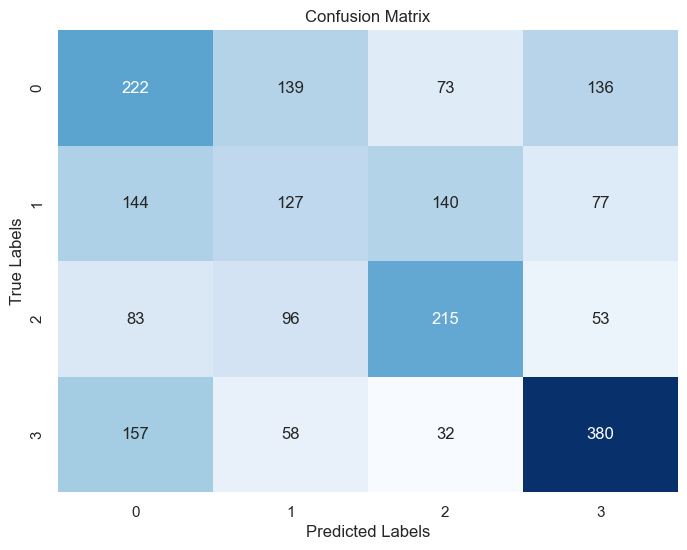

In [ ]:
# Вывод метрик качества
print("Accuracy:", accuracy)
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Визуализация матрицы ошибок
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()